# AMSC698K Homework 5
##### Elijah Kin & Noorain Noorani

In [1]:
import qiskit
import math
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

import cirq

np.random.seed(0)

### A. Construct functions to yield QFT and inverse-QFT circuits for an arbitrary number of qubits $n_q$ using (a) basic QISkit gates and (b) basic Cirq gates

Test the behavior of your quantum circuits by creating initial configurations of 8 and 12 qubits, which correspond to harmonic phase advances over all input states:

(i) 2, 4, 8 states per cycle

(ii) 6 states per cycle

(iii) apply only a $Z$-gate to qubit $n_q / 2$

Report and interpret the results from running QFT on these initial configurations and the results from running QFT and inverse-QFT.

### Qiskit QFT

In [2]:
def qft_qiskit(nq, with_swaps=True, min_angle=0.):
    circ = QuantumCircuit(nq)

    # Loop over each qubit in reverse order to build the QFT circuit.
    for i in reversed(range(nq)):
        circ.h(i)
        # For each qubit before i, apply a controlled phase (cp) gate.
        for j in reversed(range(i)):
            # Calculate the angle for the controlled phase gate.
            # Note: j-i is negative so math.pow(2, (j-i)) gives the correct fraction of π.
            mypow = math.pi * math.pow(2, (j - i))
            if mypow > min_angle:
                circ.cp(mypow, j, i)
        circ.barrier()

    # Optionally, add swap gates to reverse the order of qubits.
    if with_swaps:
        for i in range(nq // 2):
            circ.swap(i, nq - i - 1)
    return circ

def iqft_qiskit(nq, with_swaps=True, min_angle=0.):
    circ = QuantumCircuit(nq)

    # Optionally, add swap gates to reverse the order of qubits.
    if with_swaps:
        for i in reversed(range(nq // 2)):
            circ.swap(i, nq - i - 1)
        circ.barrier()

    # Build the inverse Quantum Fourier Transform (QFT) circuit.
    for i in range(nq):
        # For each qubit, add controlled phase (cp) gates from all previous qubits.
        for j in range(i):
            # Calculate the phase angle (negative for the inverse QFT).
            mypow = -math.pi * math.pow(2, (j - i))
            if abs(mypow) > min_angle:
                circ.cp(mypow, j, i)
        circ.h(i)
        circ.barrier()
    return circ

In [3]:
def run_qft_qiskit(nq, states_per_cycle, plot_circuit):
  qc = QuantumCircuit(nq)
  qc.h(list(range(nq)))
  qc.barrier(label='State Preparation')

  if states_per_cycle == '2':
    qc.rz(-np.pi, 0)
    # None
  elif states_per_cycle == '4':
    qc.rz(-np.pi / 2, 0)
    qc.rz(-np.pi, 1)
    # None
  elif states_per_cycle == '8':
    qc.rz(-np.pi / 4, 0)
    qc.rz(-np.pi / 2, 1)
    qc.rz(-np.pi, 2)
  elif states_per_cycle == '6':
    qc.rz(-np.pi / 3, 0)
    qc.rz(-2 * np.pi / 3, 1)
    qc.rz(-4 * np.pi / 3, 2)
  else:
    qc.z(nq // 2)

  backend = Aer.get_backend('statevector_simulator')
  statevector = backend.run(qc).result().get_statevector()
  # print(statevector)

  qc.barrier(label='QFT')
  qc = qc.compose(qft_qiskit(nq))
  qc.measure_all()
  if plot_circuit:
    display(qc.draw('mpl'))
  counts = Aer.get_backend('qasm_simulator').run(qc).result().get_counts()
  display(plot_histogram(counts))

8 Qubits with 2 States per Cycle


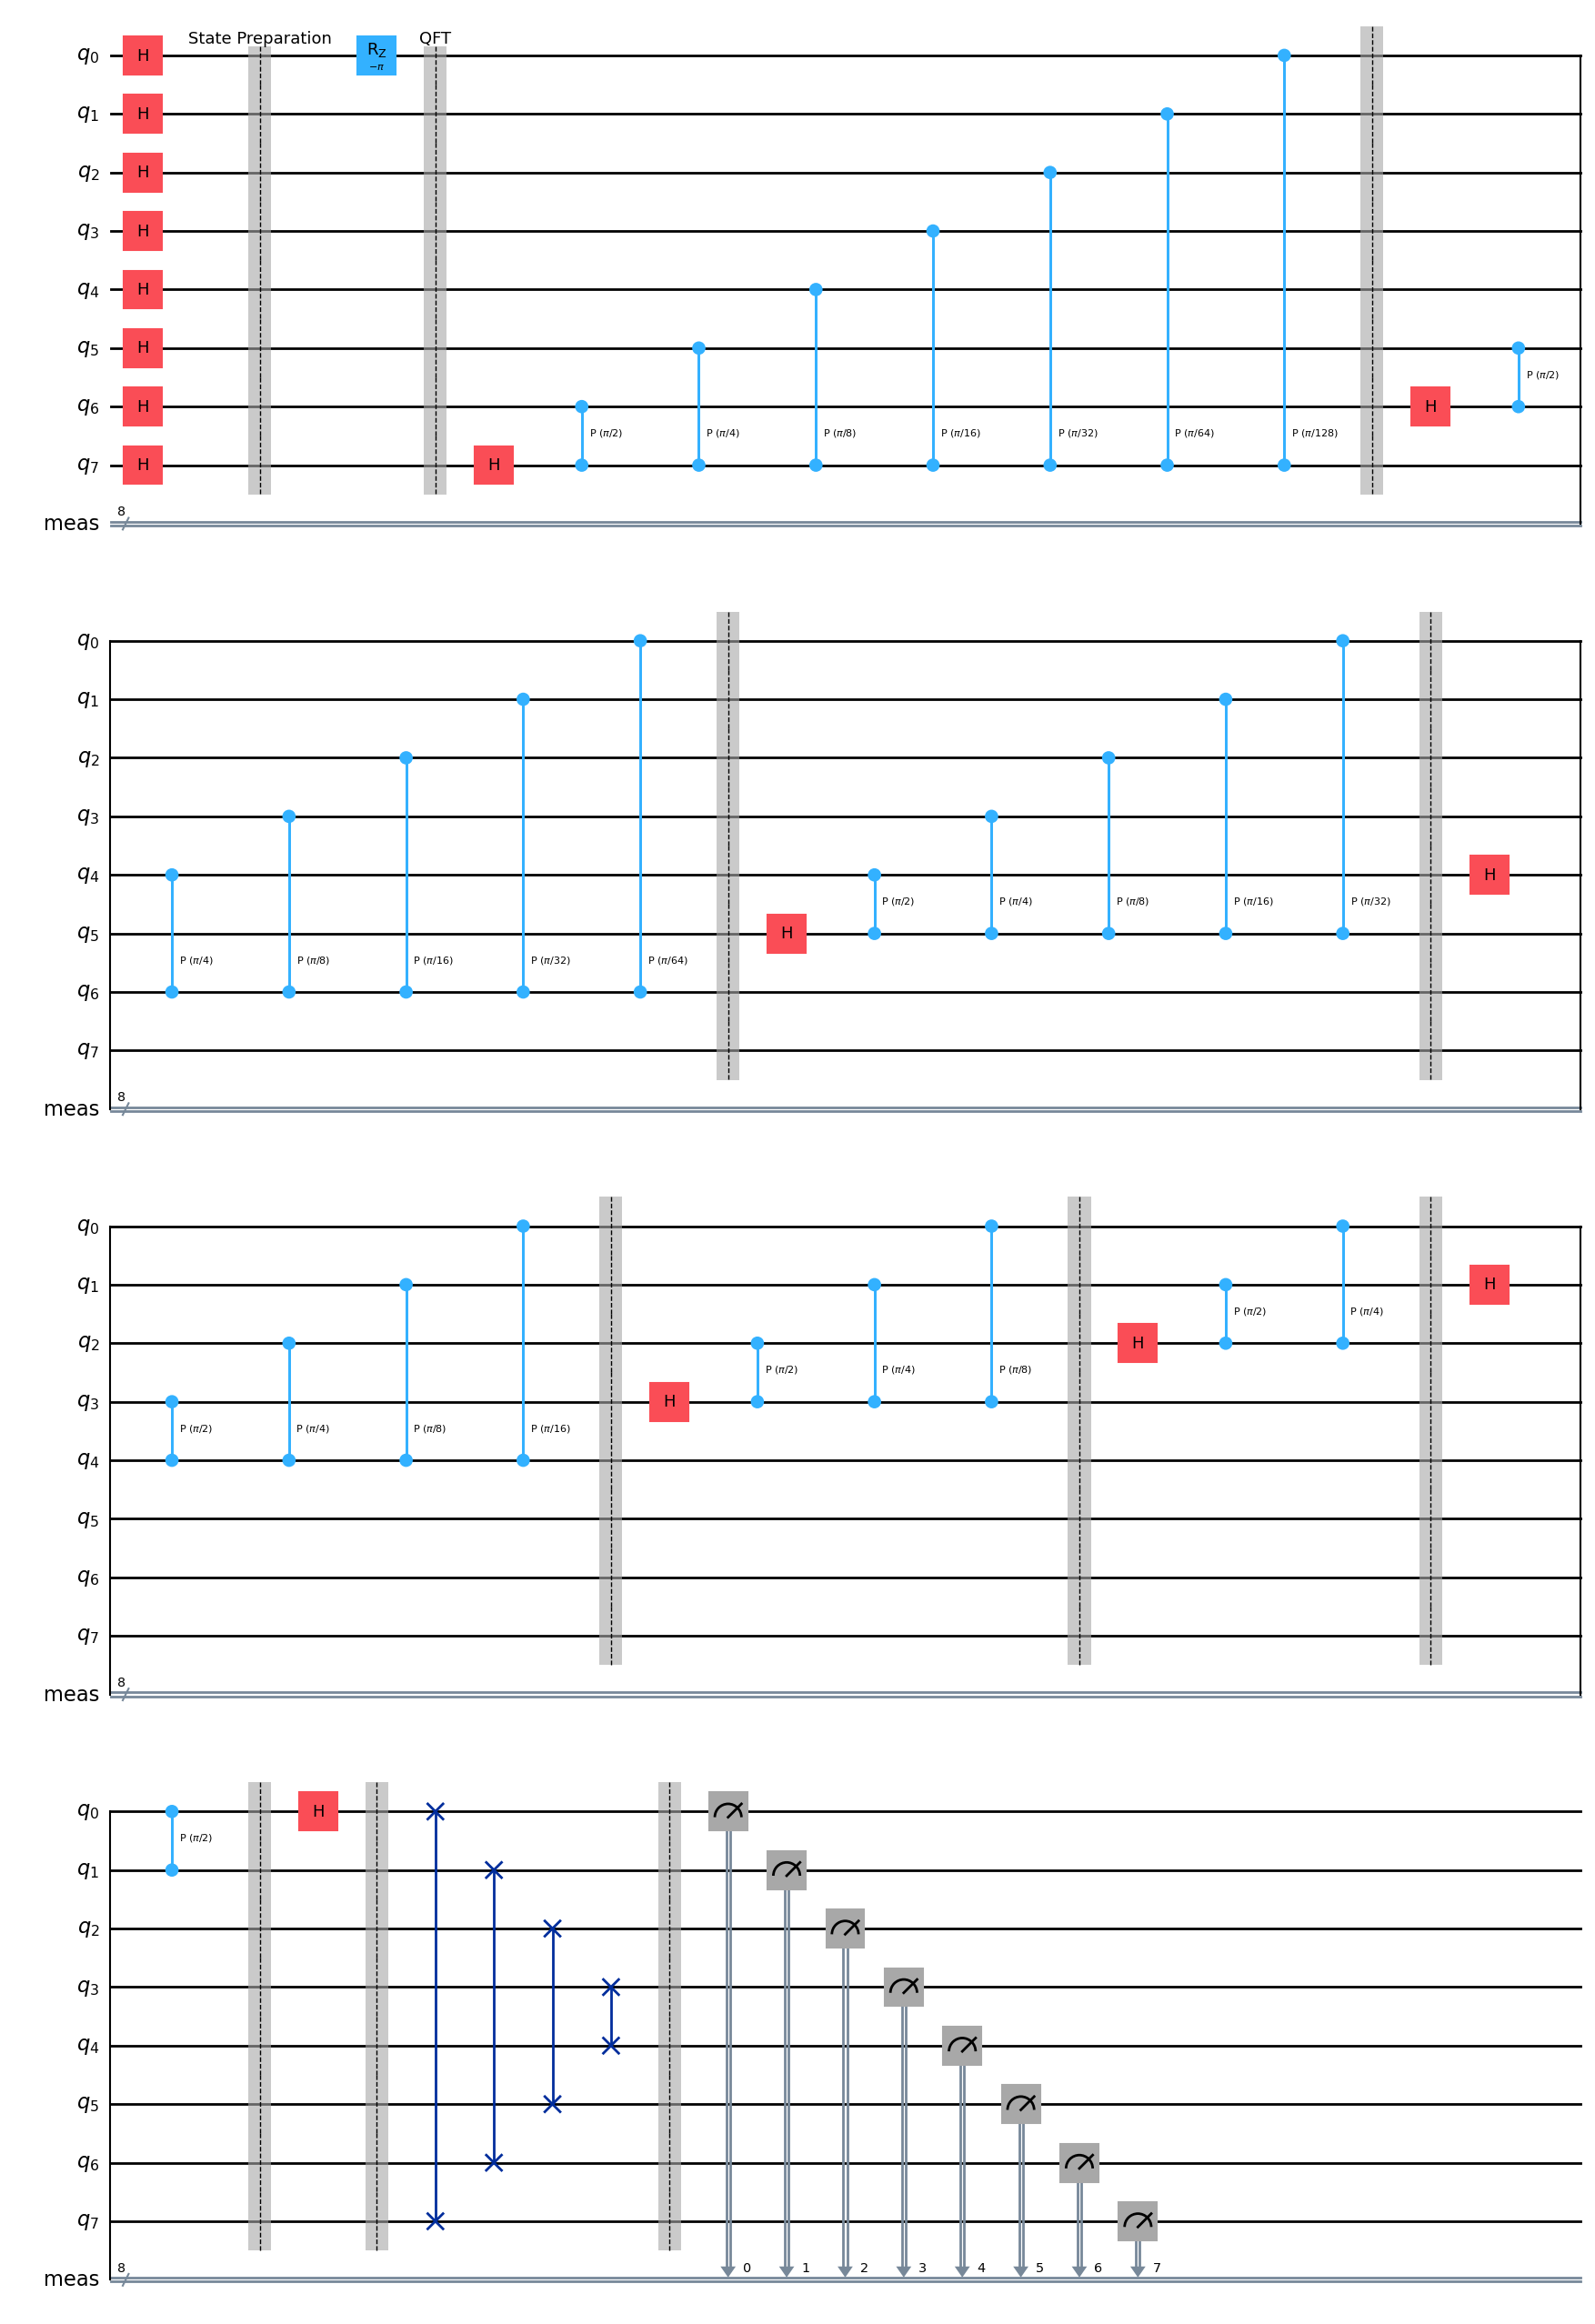

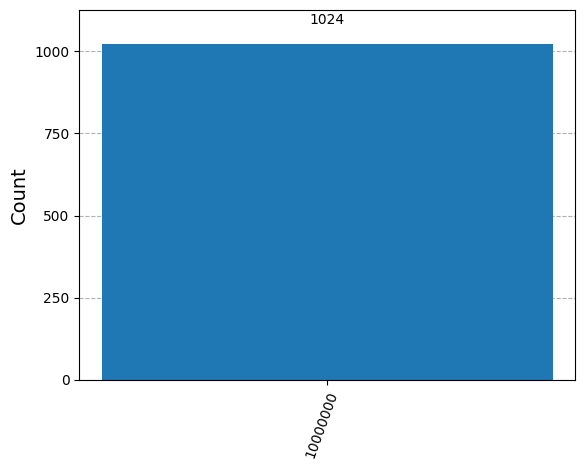

8 Qubits with 4 States per Cycle


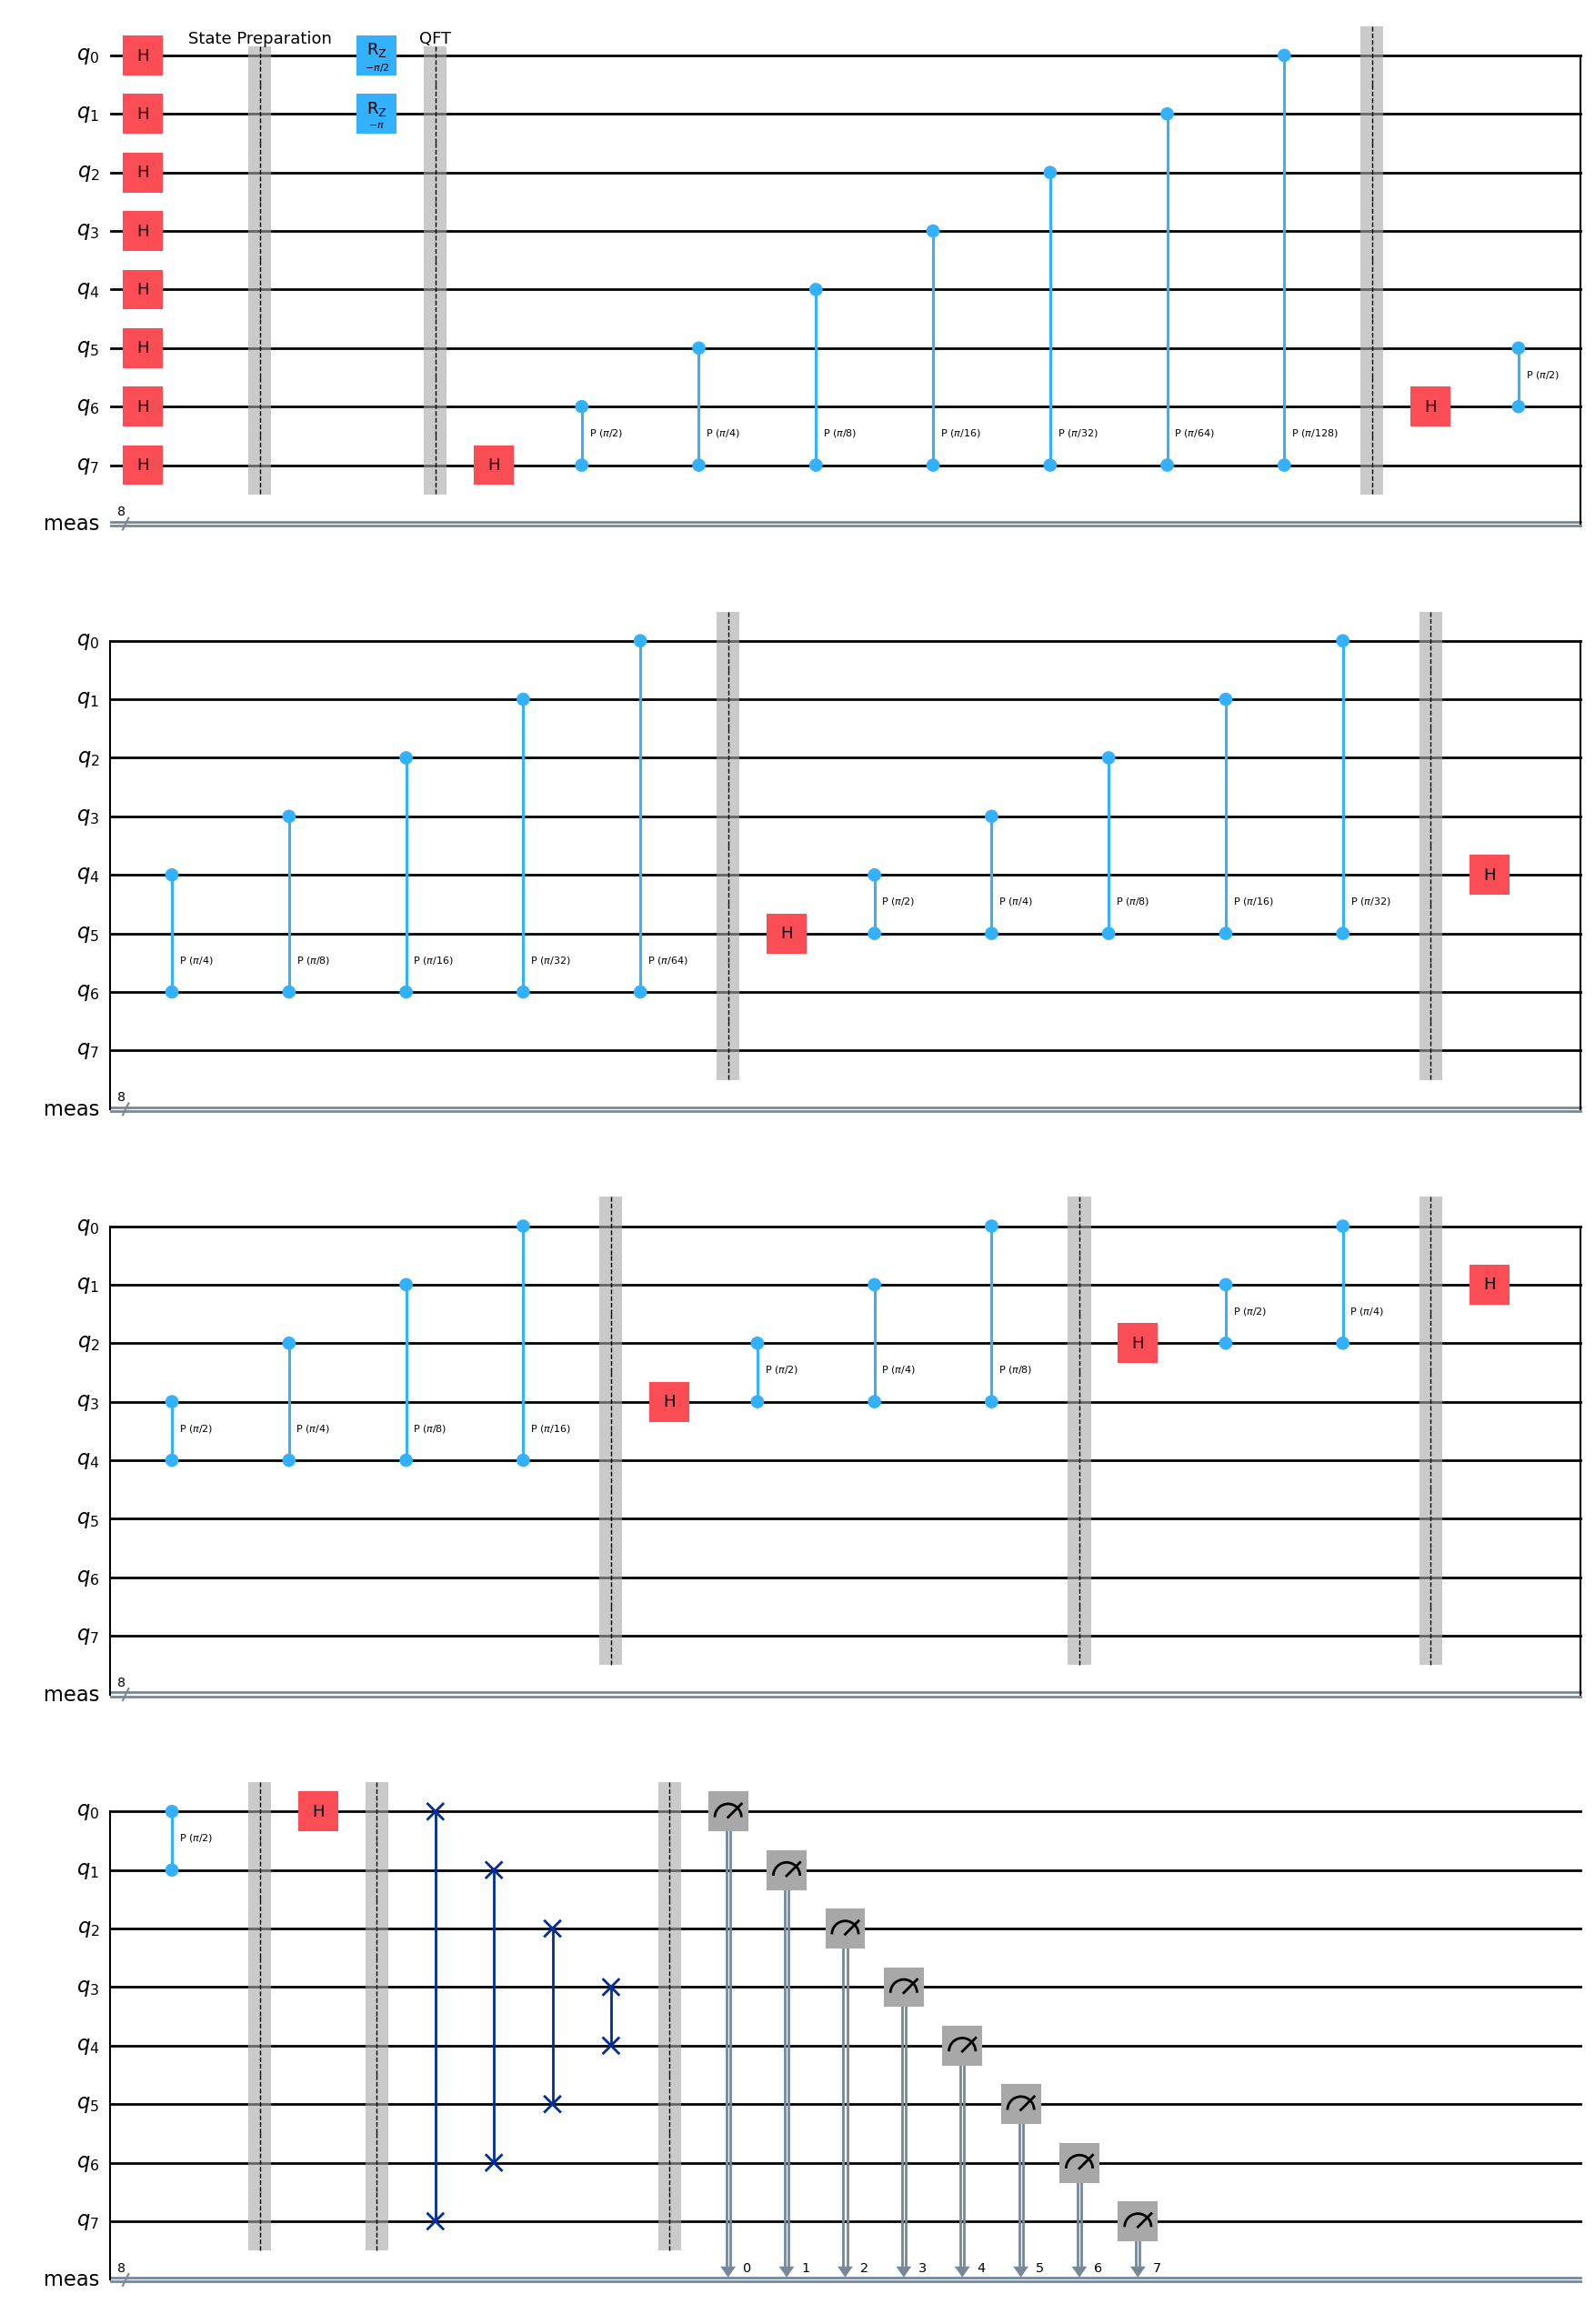

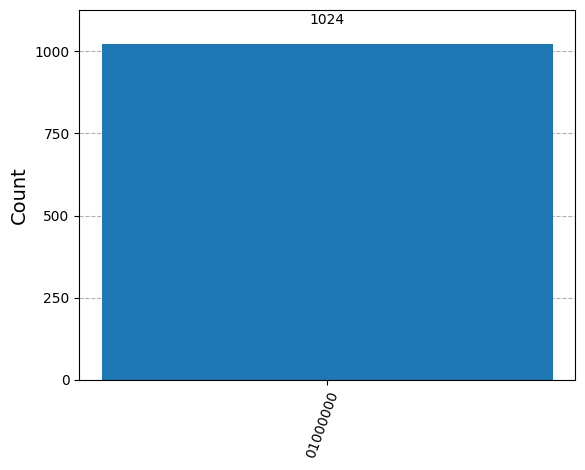

8 Qubits with 8 States per Cycle


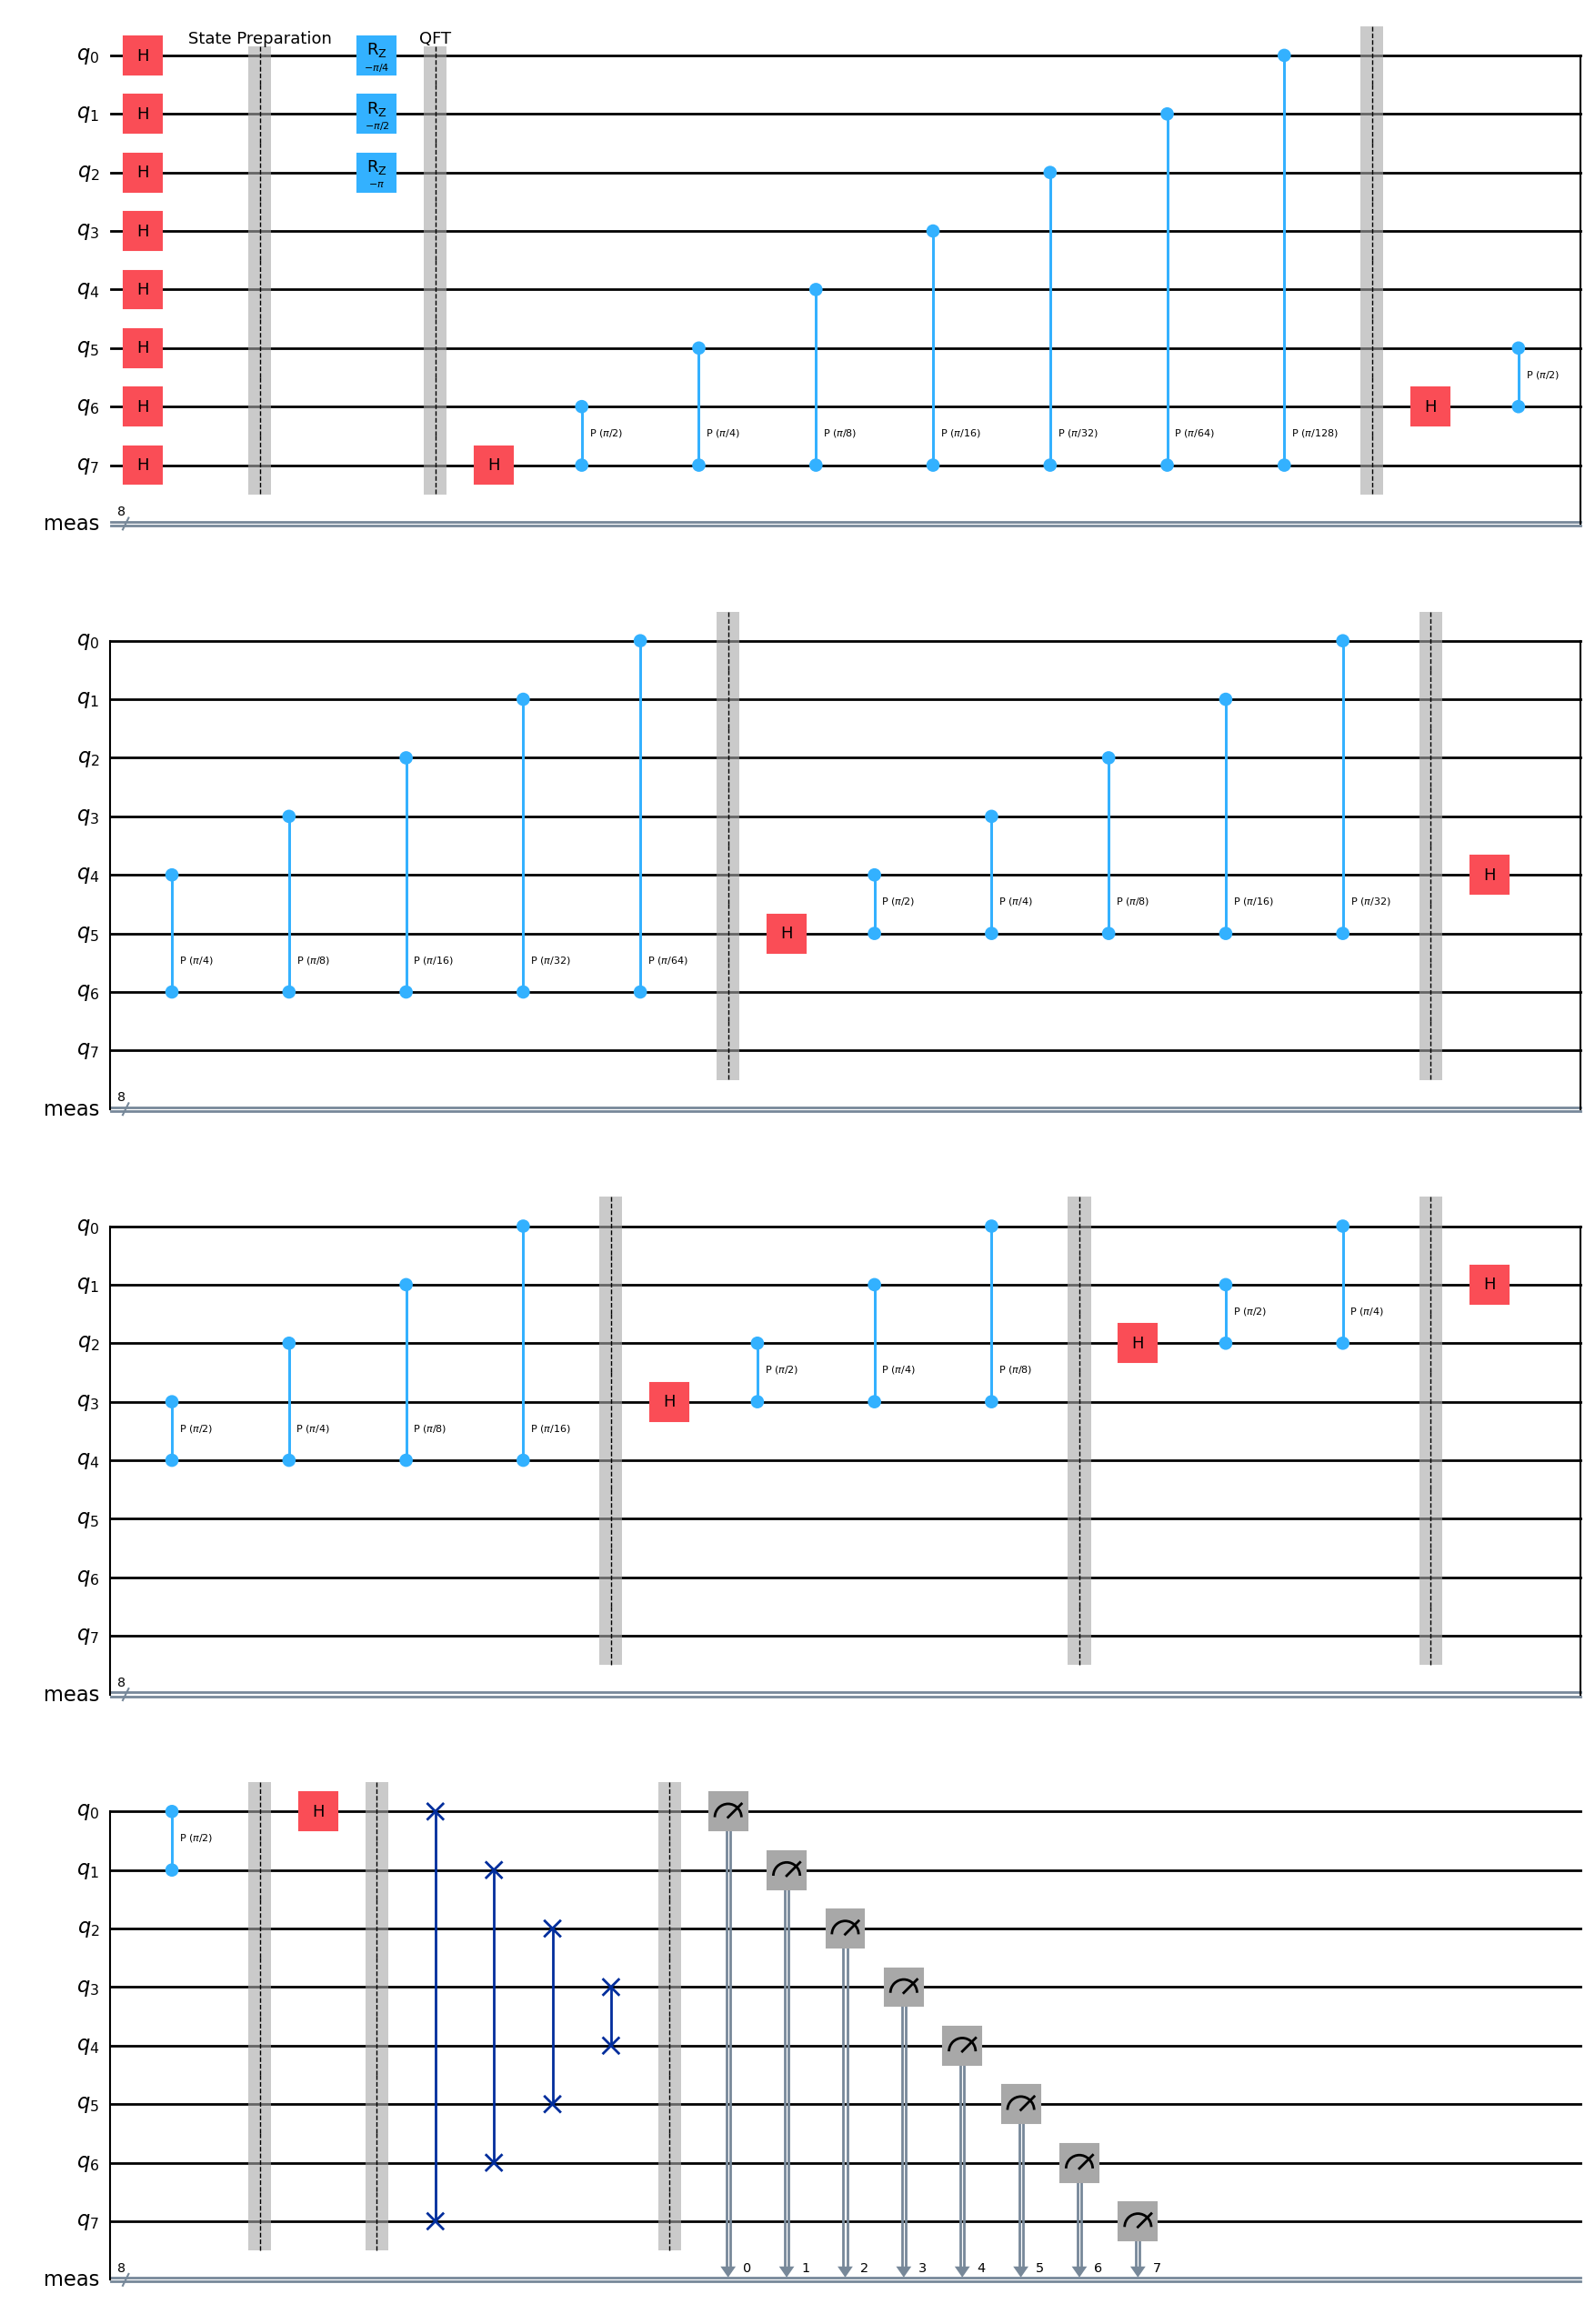

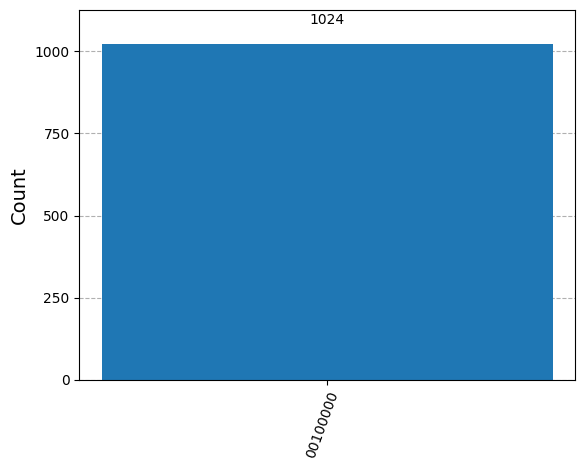

8 Qubits with 6 States per Cycle


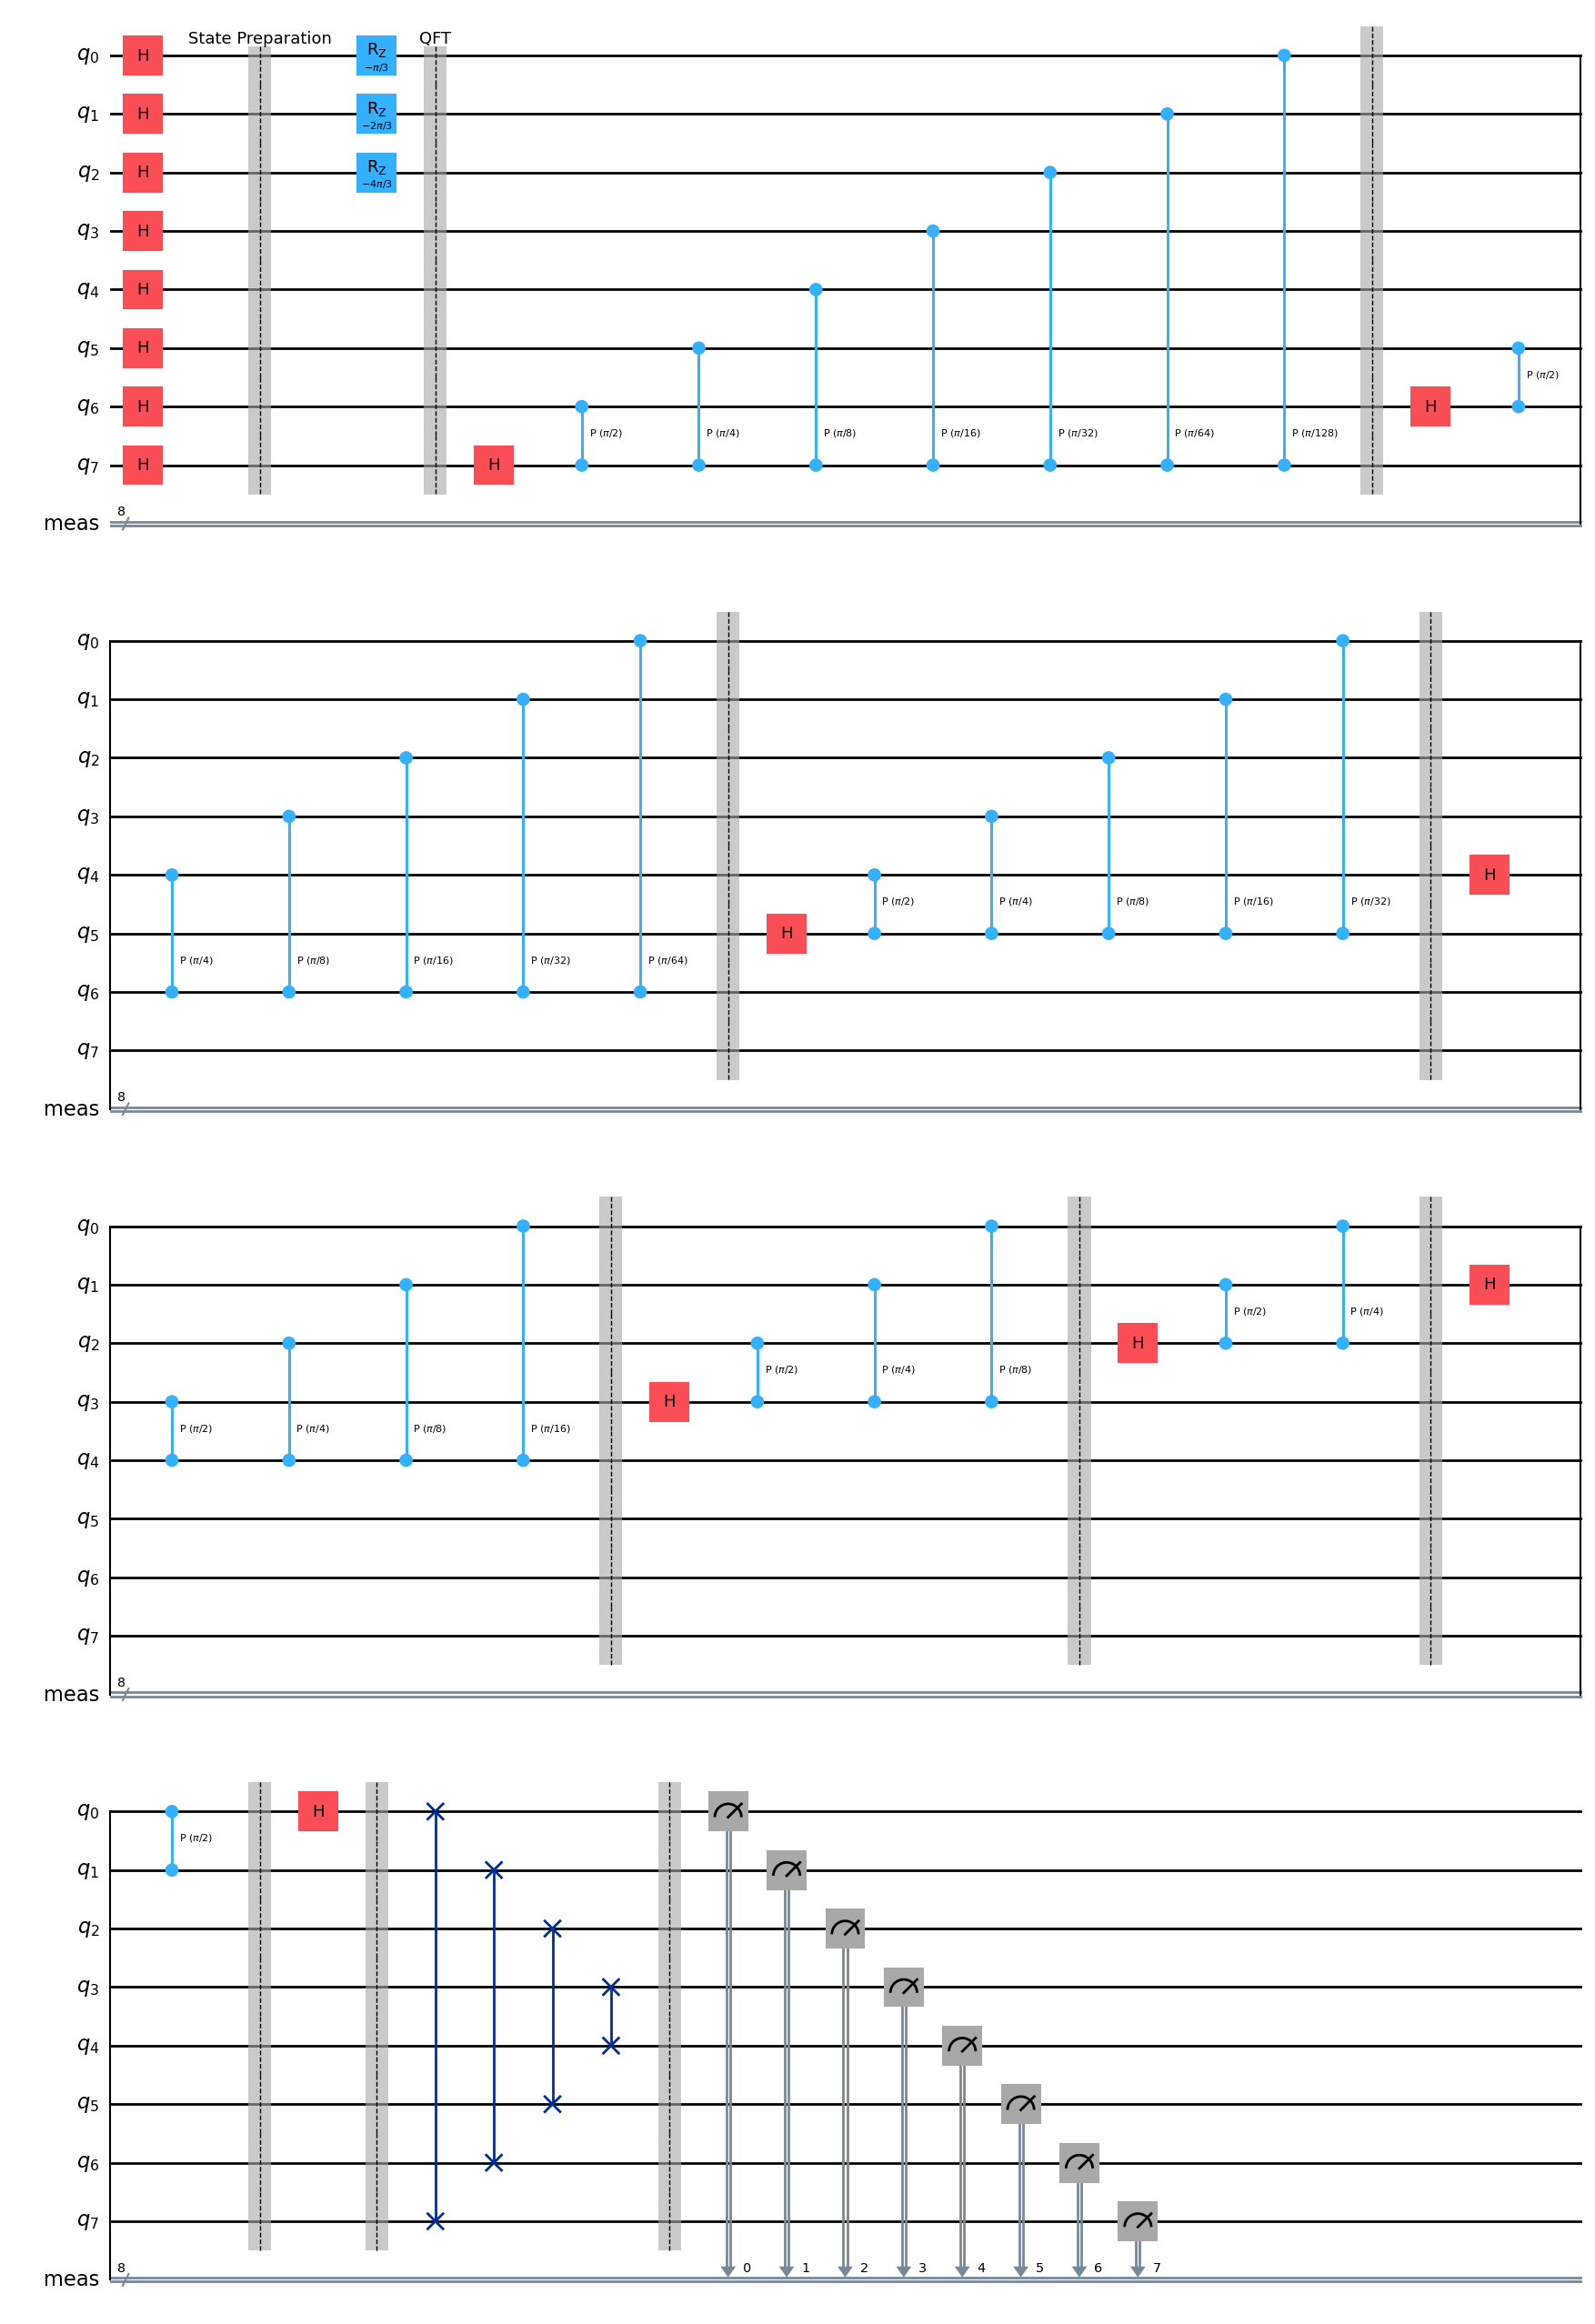

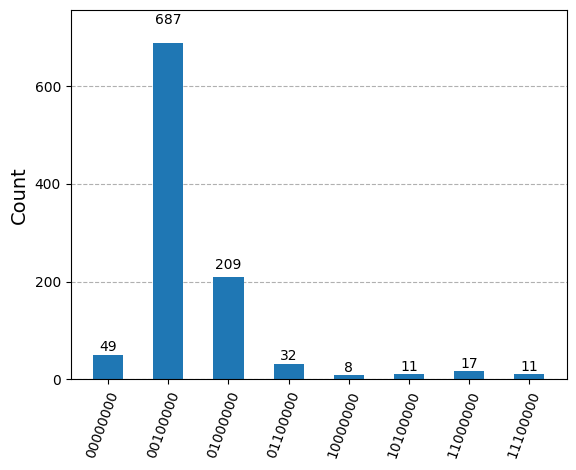

8 Qubits with a Z gate on nq / 2


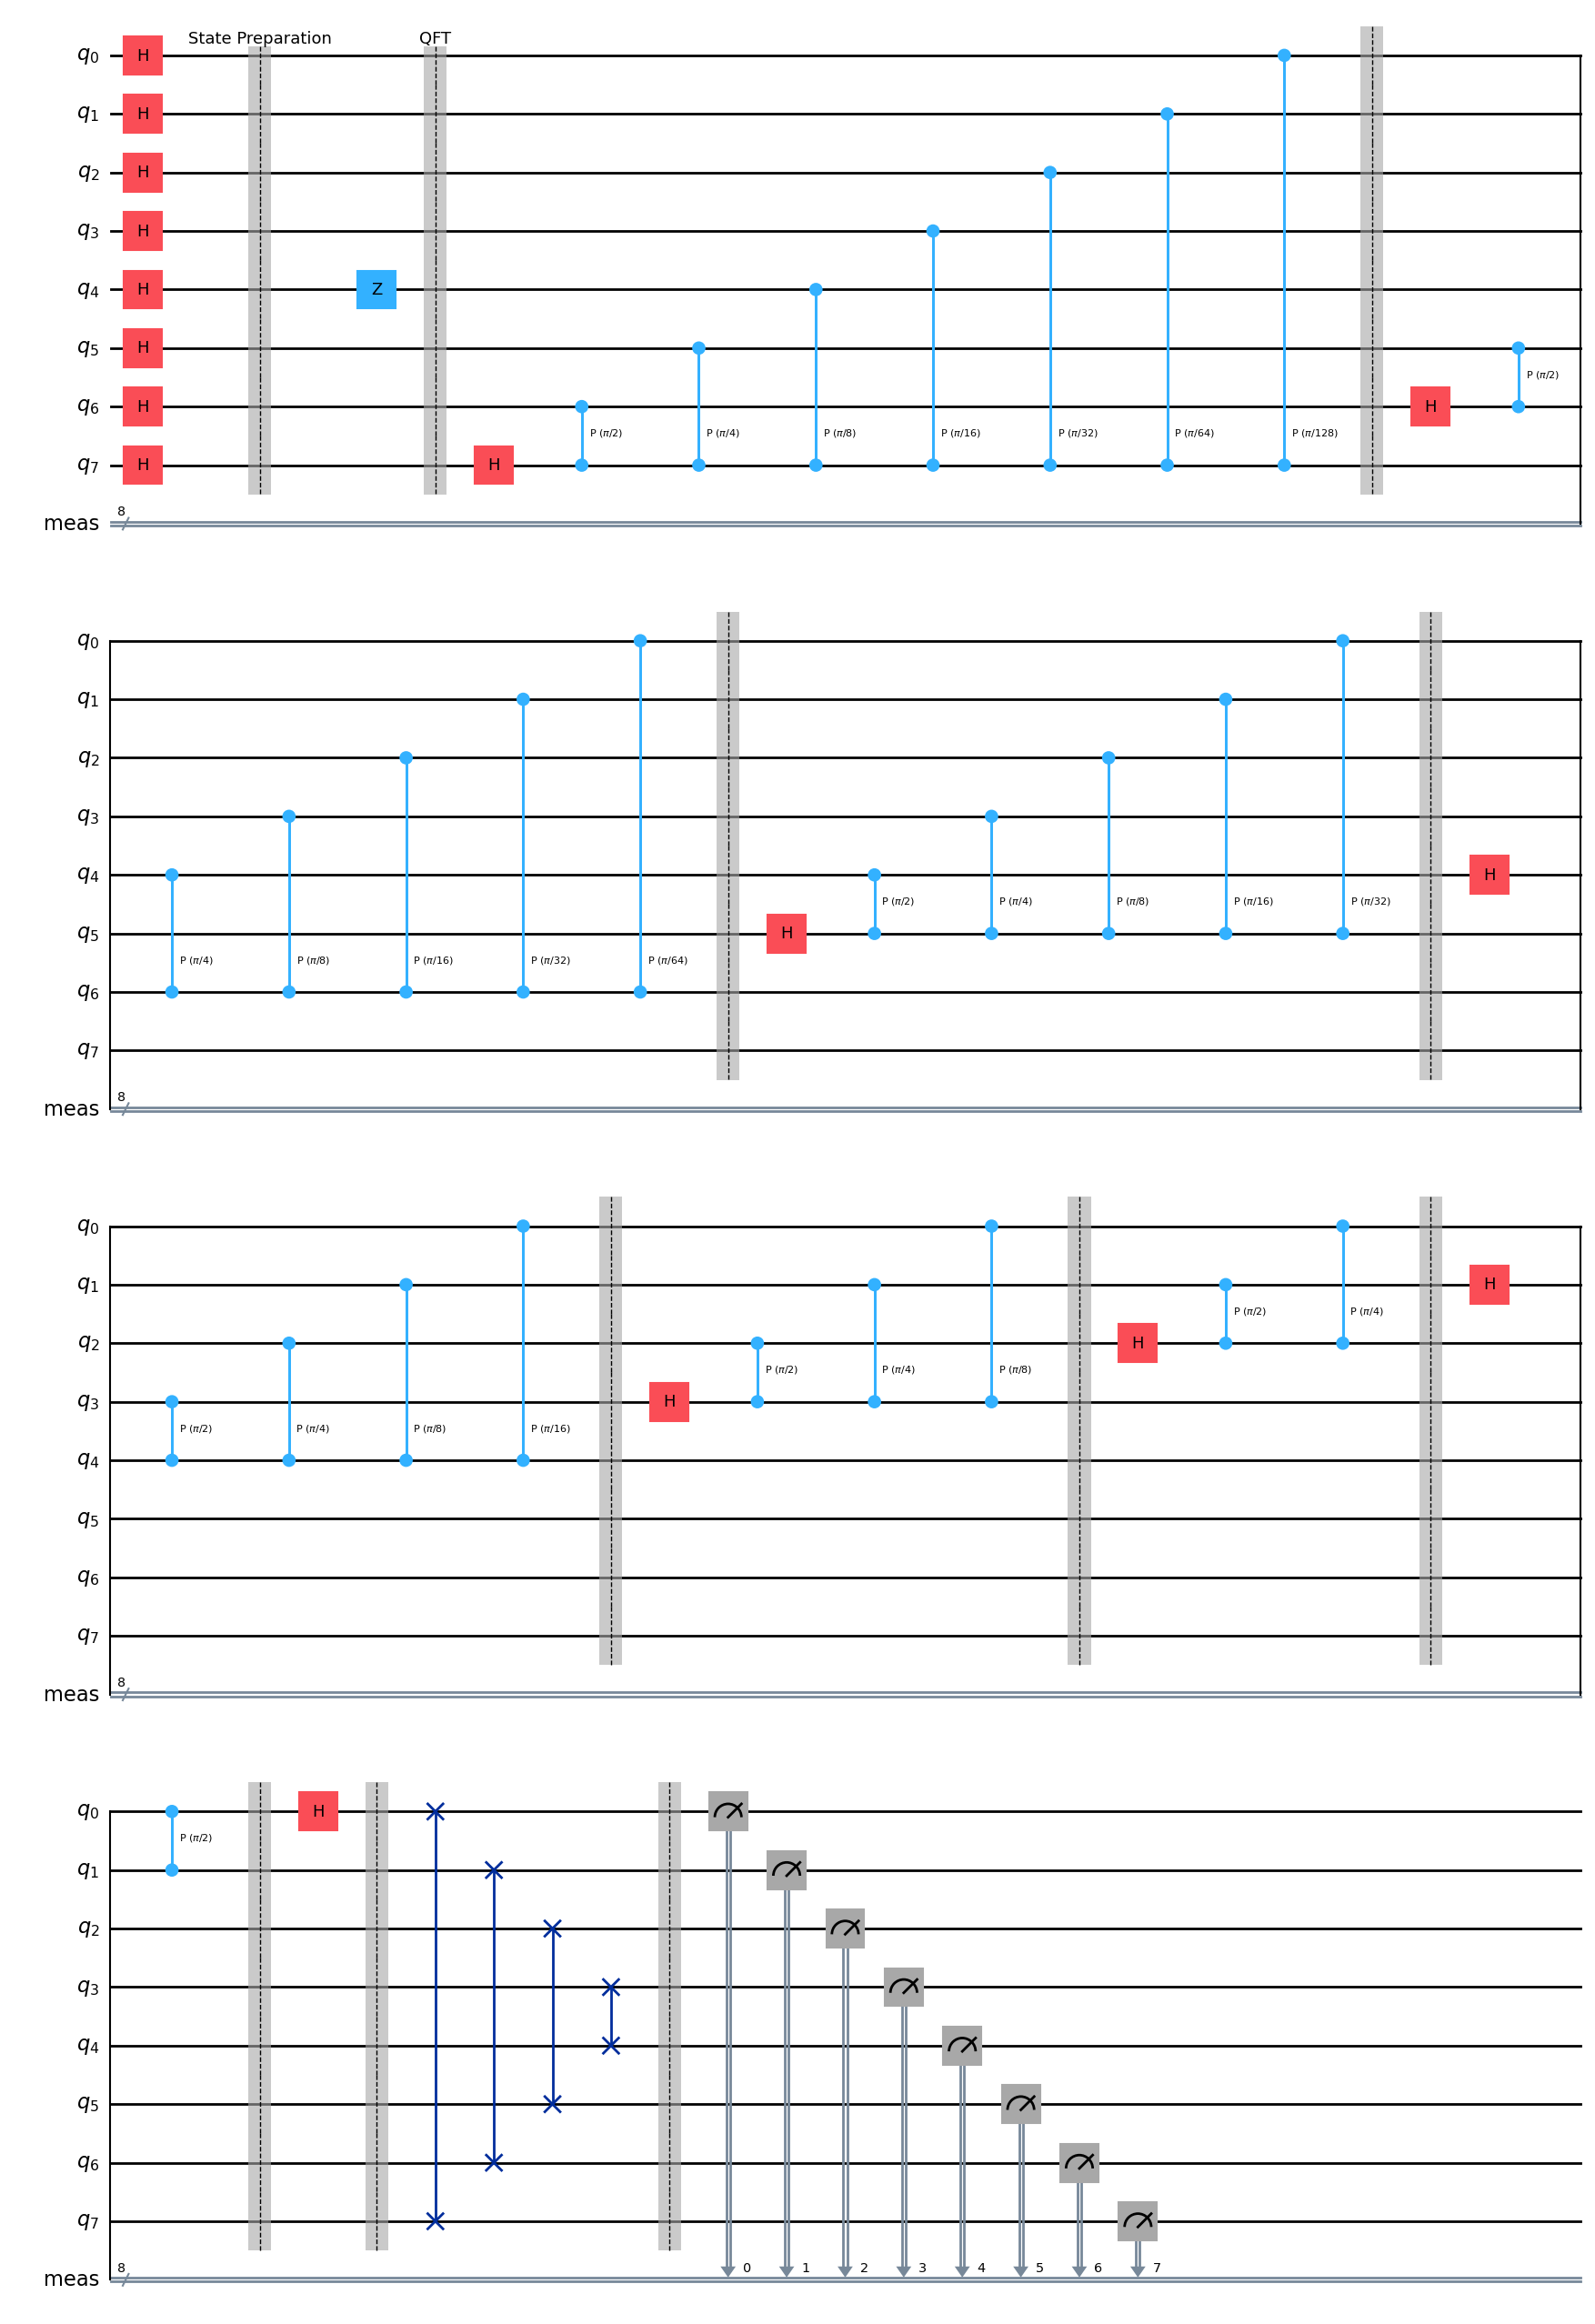

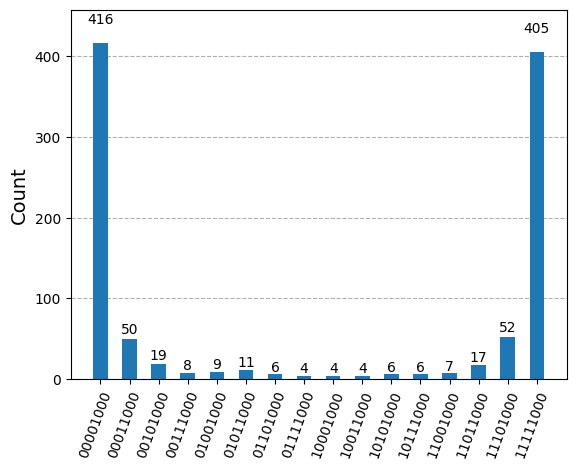

12 Qubits with 2 States per Cycle


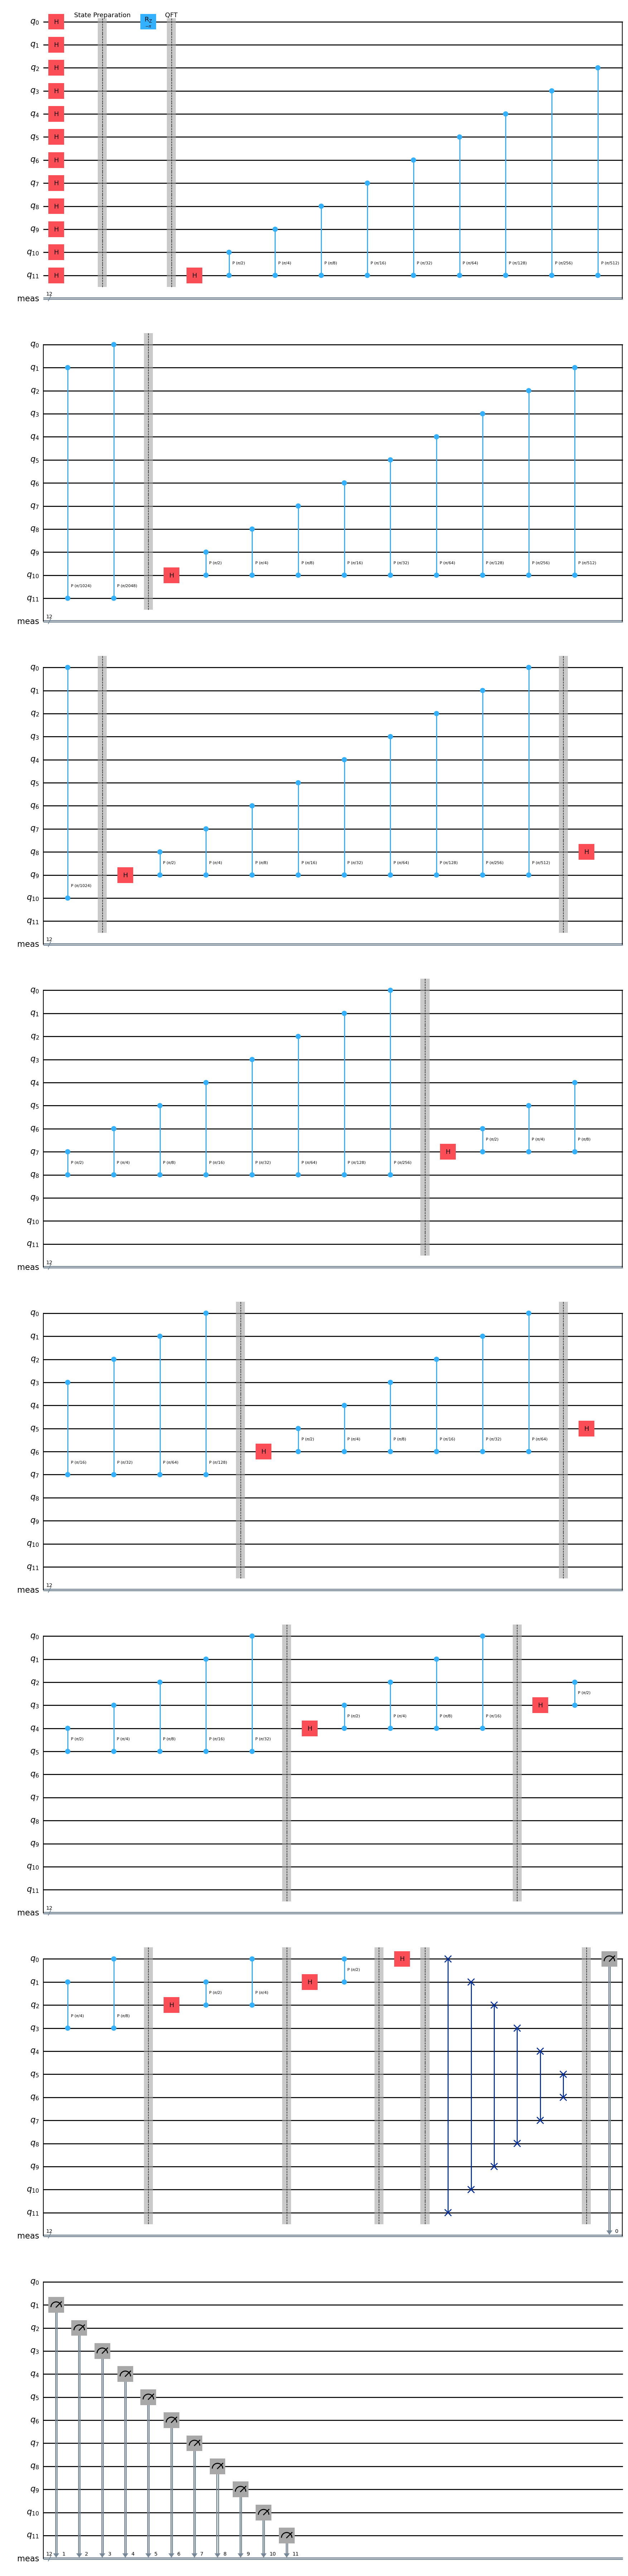

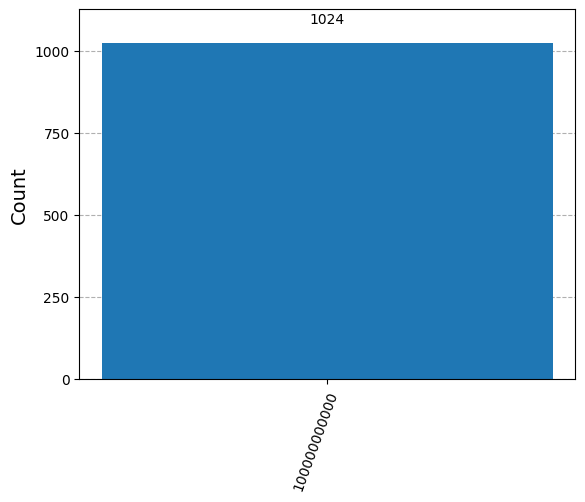

12 Qubits with 4 States per Cycle


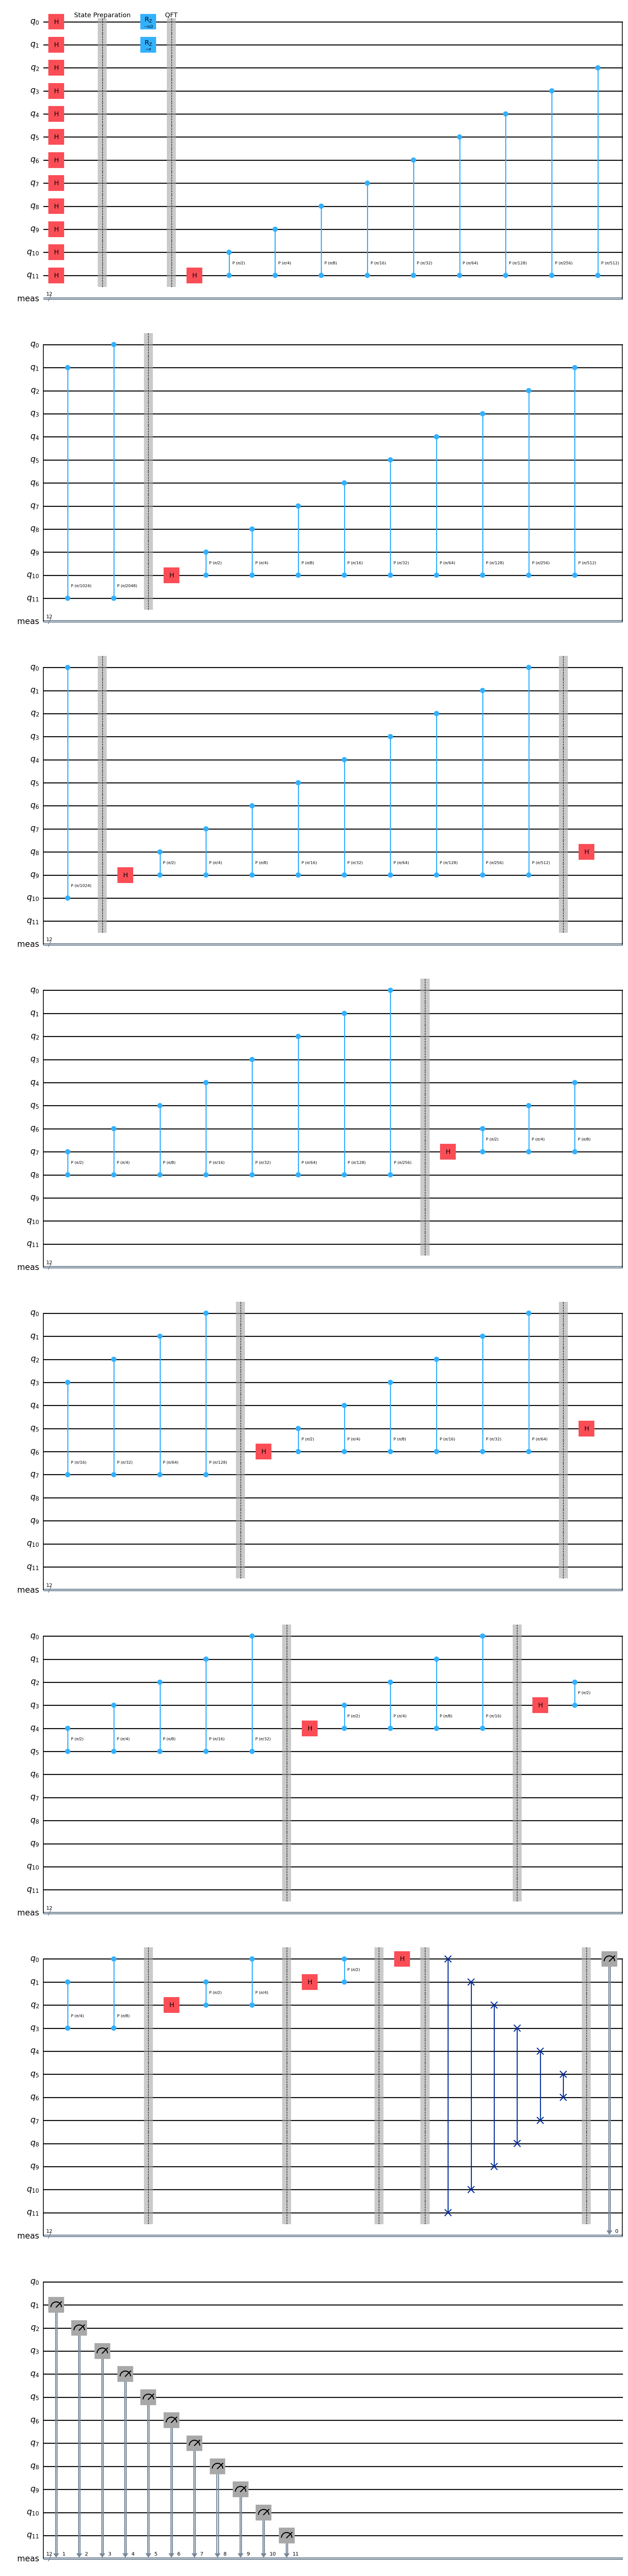

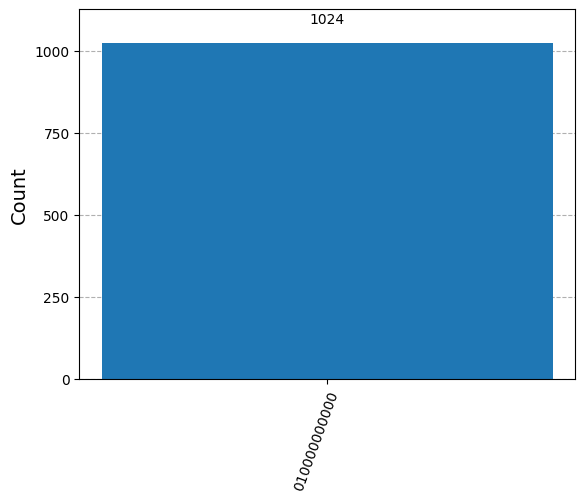

12 Qubits with 8 States per Cycle


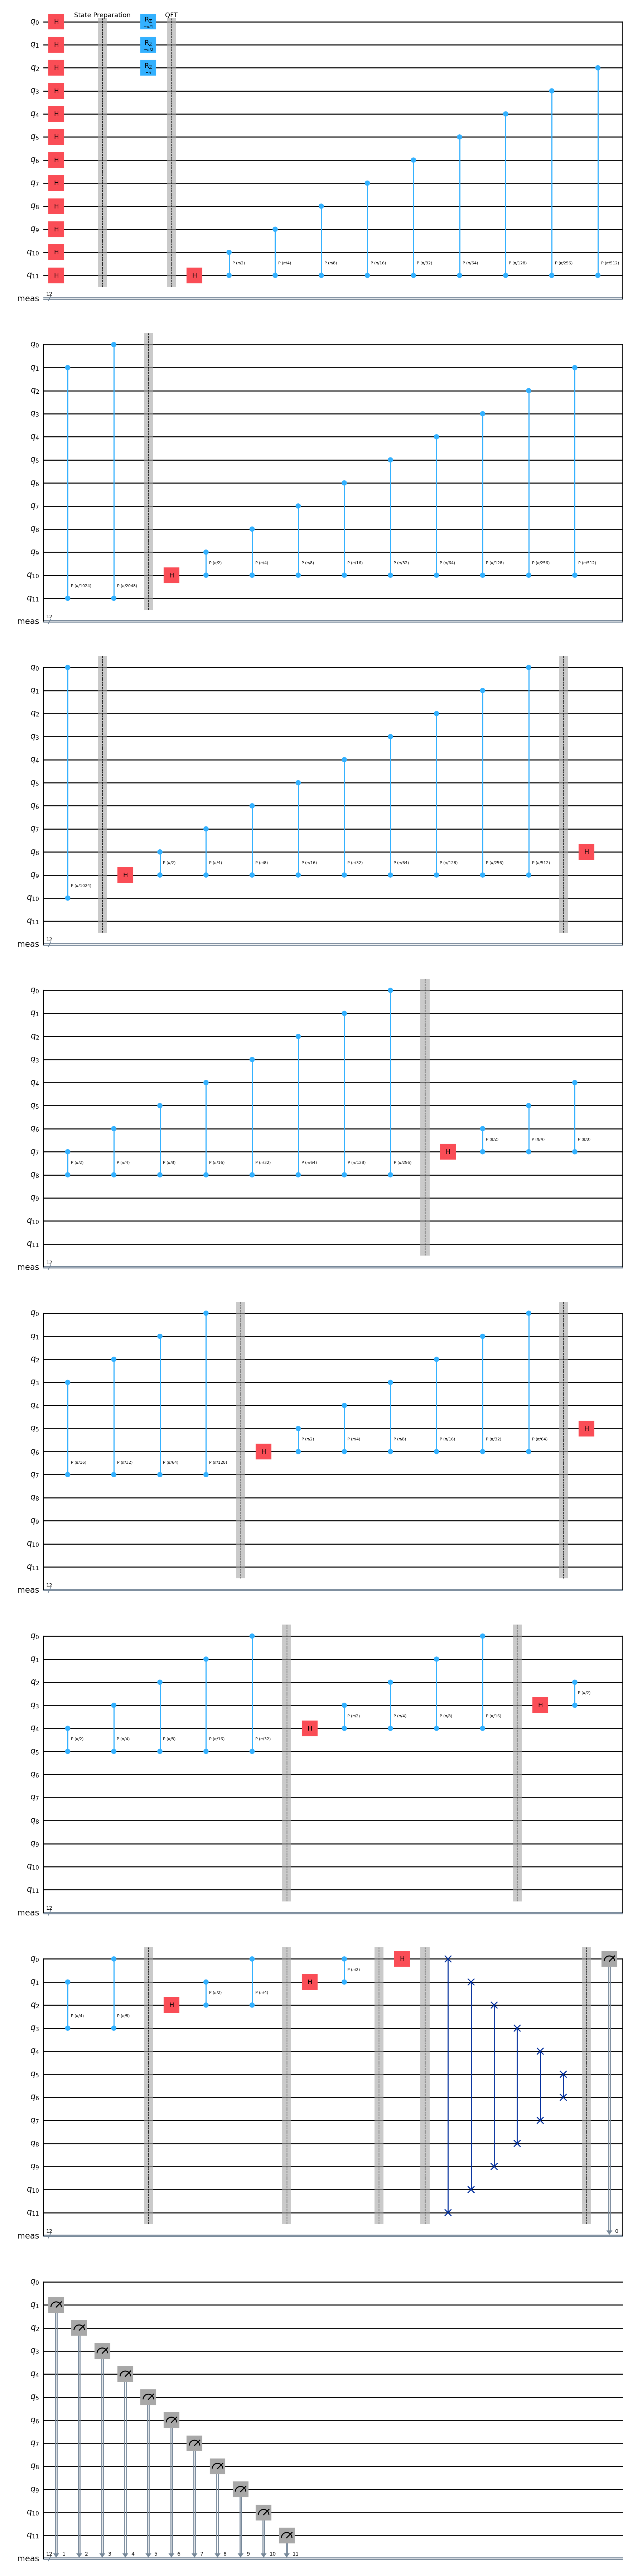

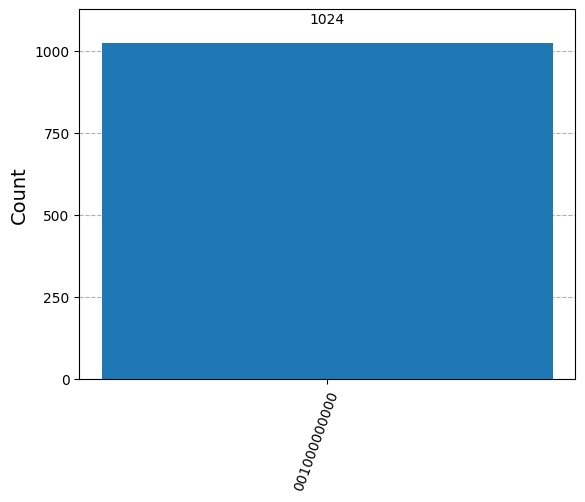

12 Qubits with 6 States per Cycle


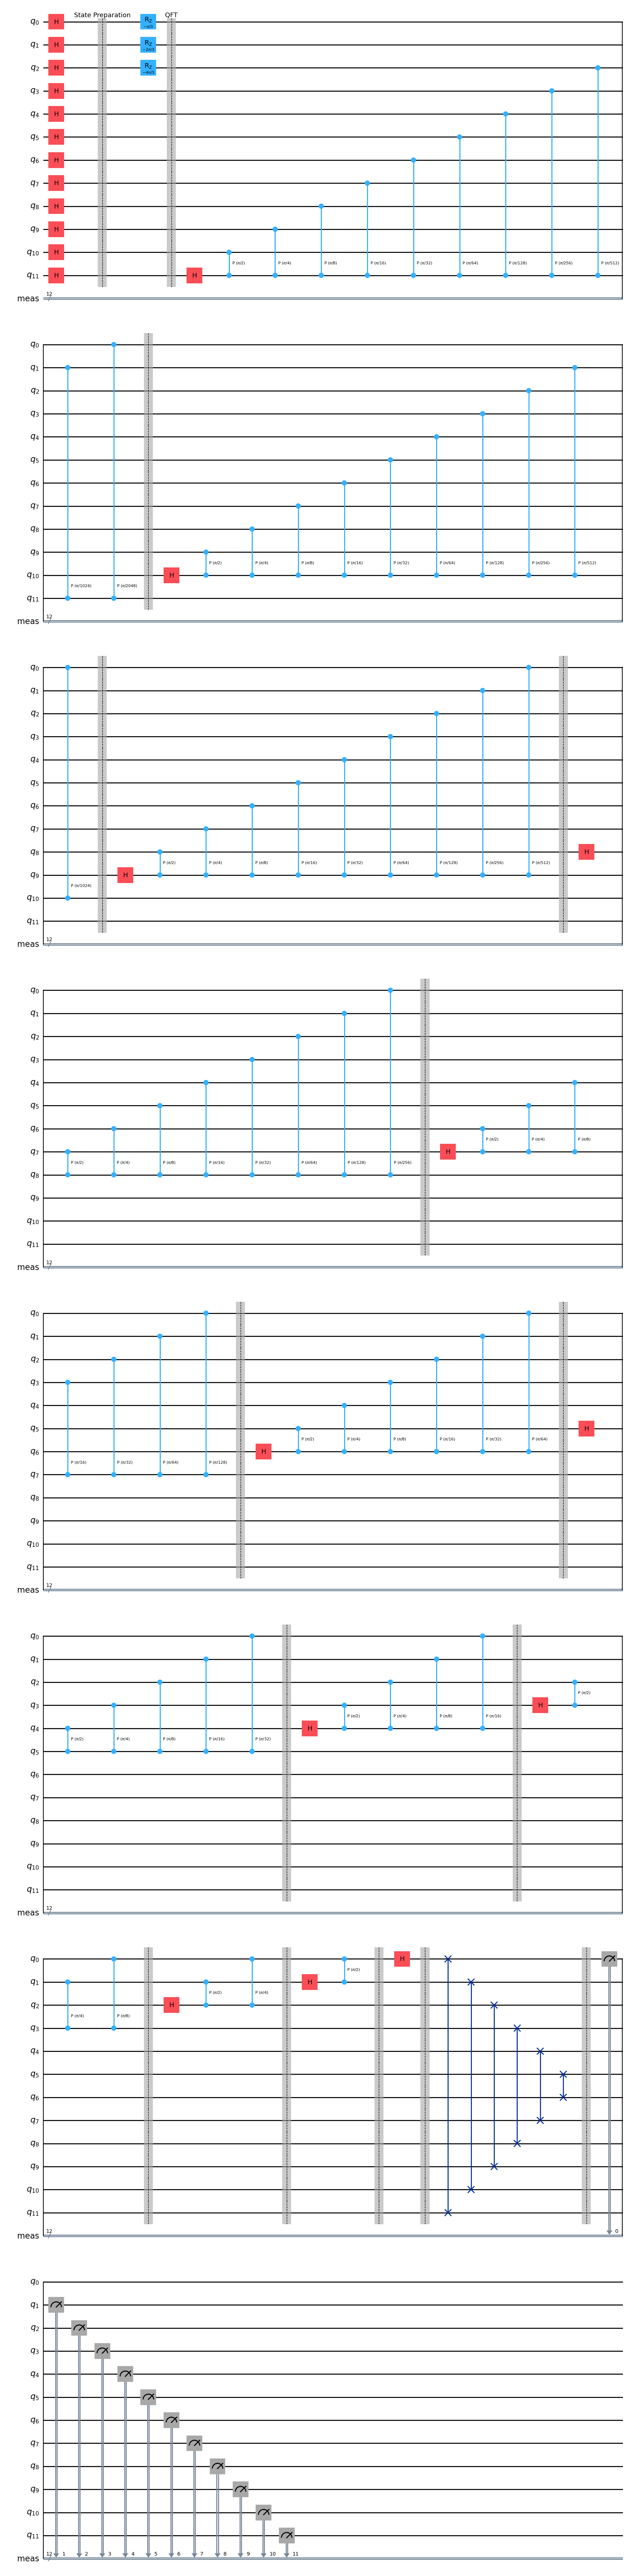

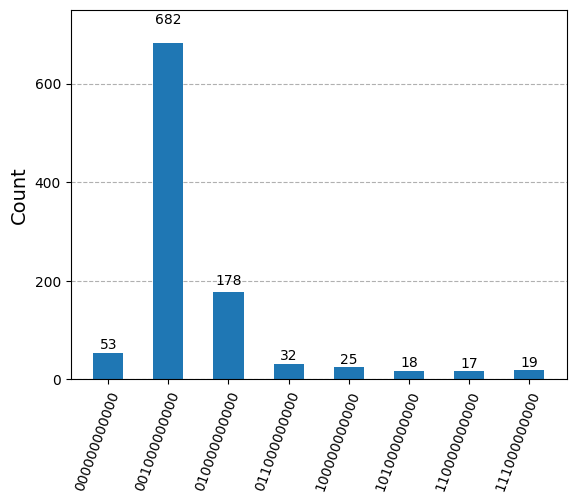

12 Qubits with a Z gate on nq / 2


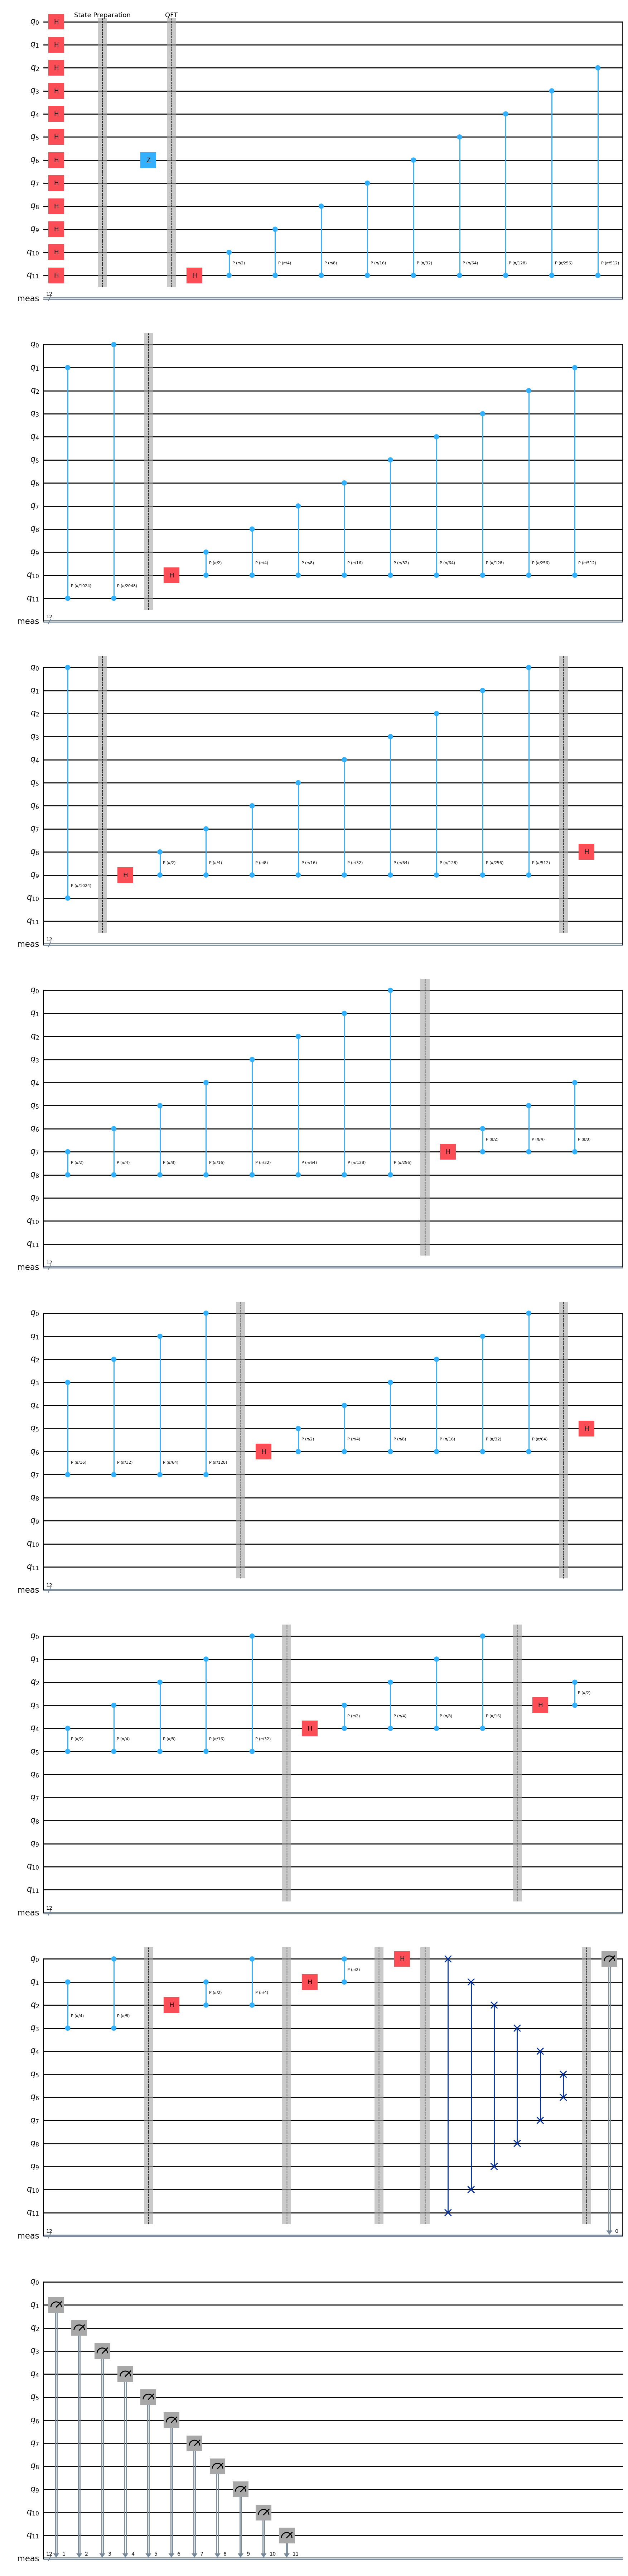

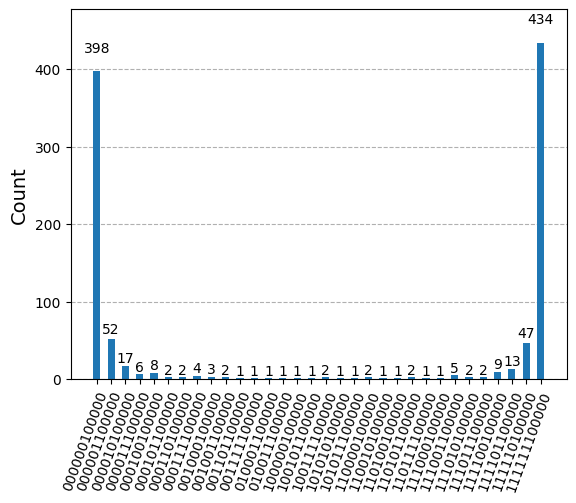

In [4]:
for nq in [8, 12]:
  for states_per_cycle in ['2', '4', '8', '6']:
    print(f'{nq} Qubits with {states_per_cycle} States per Cycle')
    run_qft_qiskit(nq, states_per_cycle, plot_circuit=True)

  print(f'{nq} Qubits with a Z gate on nq / 2')
  run_qft_qiskit(nq, None, plot_circuit=True)

### Cirq QFT

In [5]:
def qft_cirq(nq, with_swaps=True, min_angle=0.):
  qc = cirq.Circuit()
  qubits = cirq.LineQubit.range(nq)

  for i in reversed(range(nq)):
    qc.append(cirq.Moment(cirq.H(qubits[i])))
    for j in reversed(range(i)):
      mypow = math.pow(2, (i - j))
      if mypow * math.pi > min_angle:
        qc.append(cirq.Moment(cirq.CZ(qubits[j], qubits[i])**mypow))

  if with_swaps:
      for i in range(nq // 2):
        qc.append(cirq.Moment(cirq.SWAP(qubits[i], qubits[nq - i - 1])))
  return qc

def iqft_cirq(nq, with_swaps=True, min_angle=0.):
  qc = cirq.Circuit()
  qubits = cirq.LineQubit.range(nq)

  if with_swaps:
    for i in reversed(range(nq // 2)):
      qc.append(cirq.Moment(cirq.SWAP(qubits[i], qubits[nq - i - 1])))

  for i in range(nq):
    for j in range(i):
      mypow = -math.pow(2, (j - i))
      if abs(math.pi * mypow) > min_angle:
        qc.append(cirq.Moment(cirq.CZ(qubits[j], qubits[i])**mypow))
    qc.append(cirq.Moment(cirq.H(qubits[i])))
  return qc

In [6]:
def run_qft_cirq(nq, states_per_cycle, plot_circuit):
  qc = cirq.Circuit()
  qubits = cirq.LineQubit.range(nq)
  for i in range(nq):
    qc.append(cirq.H(qubits[i]))

  if states_per_cycle == '2':
    qc.append(cirq.Rz(rads=-np.pi).on(qubits[0]))
  elif states_per_cycle == '4':
    qc.append(cirq.Rz(rads=-np.pi / 2).on(qubits[0]))
    qc.append(cirq.Rz(rads=-np.pi).on(qubits[1]))
  elif states_per_cycle == '8':
    qc.append(cirq.Rz(rads=-np.pi / 4).on(qubits[0]))
    qc.append(cirq.Rz(rads=-np.pi / 2).on(qubits[1]))
    qc.append(cirq.Rz(rads=-np.pi).on(qubits[2]))
  elif states_per_cycle == '6':
    qc.append(cirq.Rz(rads=-np.pi / 3).on(qubits[0]))
    qc.append(cirq.Rz(rads=-2 * np.pi / 3).on(qubits[1]))
    qc.append(cirq.Rz(rads=-4 * np.pi / 3).on(qubits[2]))
  else:
    qc.append(cirq.Z(qubits[nq // 2]))

  qc.append(qft_cirq(nq))
  qc.append(cirq.measure(*qubits, key='b'))
  if plot_circuit:
    print(qc)
  samples = cirq.Simulator().run(qc, repetitions=1024)
  histogram = samples.histogram(key='b')
  cirq.plot_state_histogram(histogram, plt.subplot())
  plt.show()

8 Qubits with 2 States per Cycle
0: ───H───Rz(-π)───────────────────────────────────────────@───────────────────────────────────────@─────────────────────────────────@───────────────────────────@─────────────────────@───────────────@─────────@─────H───×───────────────M('b')───
                                                           │                                       │                                 │                           │                     │               │         │         │               │
1: ───H──────────────────────────────────────────────@─────┼─────────────────────────────────@─────┼───────────────────────────@─────┼─────────────────────@─────┼───────────────@─────┼─────────@─────┼─────H───@^0───────┼───×───────────M────────
                                                     │     │                                 │     │                           │     │                     │     │               │     │         │     │                   │   │           │
2: 

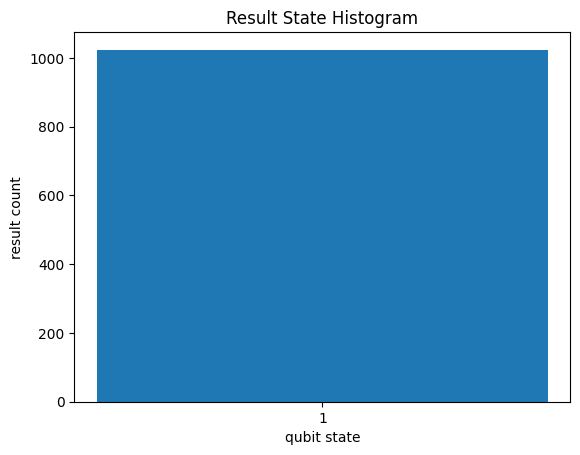

8 Qubits with 4 States per Cycle
0: ───H───Rz(-0.5π)───────────────────────────────────────────@───────────────────────────────────────@─────────────────────────────────@───────────────────────────@─────────────────────@───────────────@─────────@─────H───×───────────────M('b')───
                                                              │                                       │                                 │                           │                     │               │         │         │               │
1: ───H───Rz(-π)────────────────────────────────────────@─────┼─────────────────────────────────@─────┼───────────────────────────@─────┼─────────────────────@─────┼───────────────@─────┼─────────@─────┼─────H───@^0───────┼───×───────────M────────
                                                        │     │                                 │     │                           │     │                     │     │               │     │         │     │                   │   │    

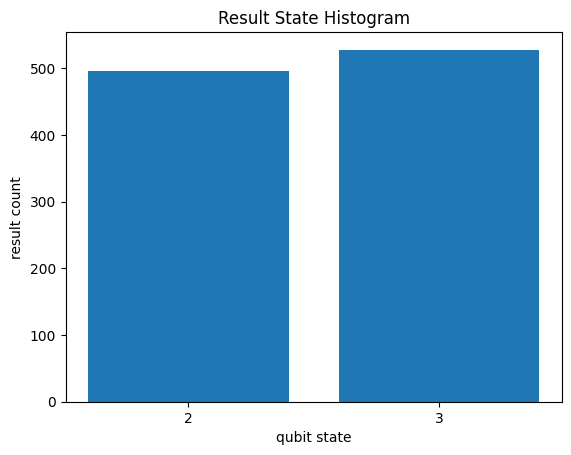

8 Qubits with 8 States per Cycle
0: ───H───Rz(-0.25π)───────────────────────────────────────────@───────────────────────────────────────@─────────────────────────────────@───────────────────────────@─────────────────────@───────────────@─────────@─────H───×───────────────M('b')───
                                                               │                                       │                                 │                           │                     │               │         │         │               │
1: ───H───Rz(-0.5π)──────────────────────────────────────@─────┼─────────────────────────────────@─────┼───────────────────────────@─────┼─────────────────────@─────┼───────────────@─────┼─────────@─────┼─────H───@^0───────┼───×───────────M────────
                                                         │     │                                 │     │                           │     │                     │     │               │     │         │     │                   │   │

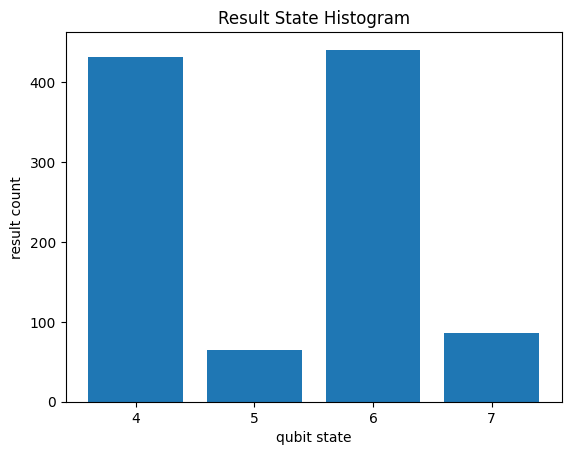

8 Qubits with 6 States per Cycle
0: ───H───Rz(-0.333π)───────────────────────────────────────────@───────────────────────────────────────@─────────────────────────────────@───────────────────────────@─────────────────────@───────────────@─────────@─────H───×───────────────M('b')───
                                                                │                                       │                                 │                           │                     │               │         │         │               │
1: ───H───Rz(-0.667π)─────────────────────────────────────@─────┼─────────────────────────────────@─────┼───────────────────────────@─────┼─────────────────────@─────┼───────────────@─────┼─────────@─────┼─────H───@^0───────┼───×───────────M────────
                                                          │     │                                 │     │                           │     │                     │     │               │     │         │     │                   │

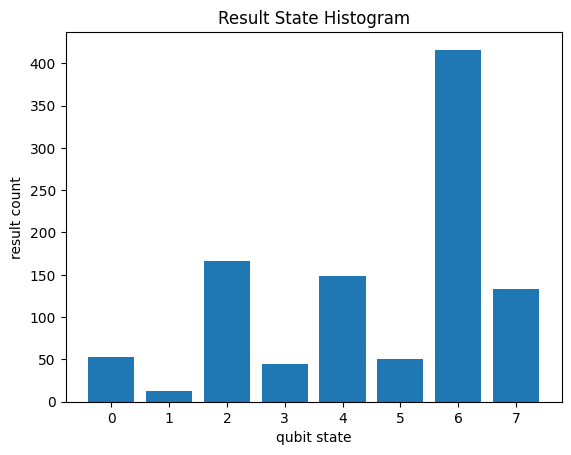

8 Qubits with a Z gate on nq / 2
0: ───H───────────────────────────────────────────────@───────────────────────────────────────@─────────────────────────────────@───────────────────────────@─────────────────────@───────────────@─────────@─────H───×───────────────M('b')───
                                                      │                                       │                                 │                           │                     │               │         │         │               │
1: ───H─────────────────────────────────────────@─────┼─────────────────────────────────@─────┼───────────────────────────@─────┼─────────────────────@─────┼───────────────@─────┼─────────@─────┼─────H───@^0───────┼───×───────────M────────
                                                │     │                                 │     │                           │     │                     │     │               │     │         │     │                   │   │           │
2: ───H────────────────

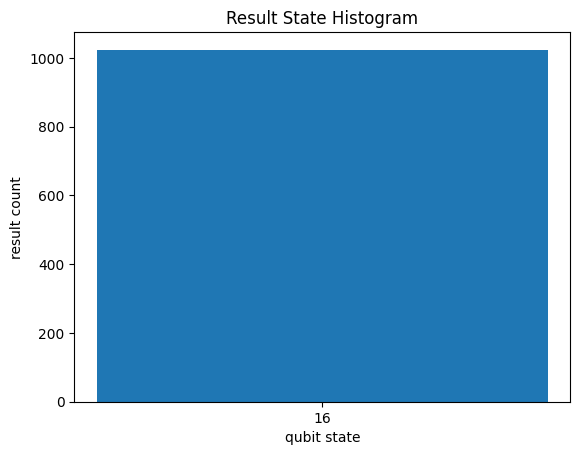

12 Qubits with 2 States per Cycle
0: ────H───Rz(-π)───────────────────────────────────────────────────────────────────@───────────────────────────────────────────────────────────────@─────────────────────────────────────────────────────────@───────────────────────────────────────────────────@─────────────────────────────────────────────@───────────────────────────────────────@─────────────────────────────────@───────────────────────────@─────────────────────@───────────────@─────────@─────H───×───────────────────────M('b')───
                                                                                    │                                                               │                                                         │                                                   │                                             │                                       │                                 │                           │                     │               │         │         │   

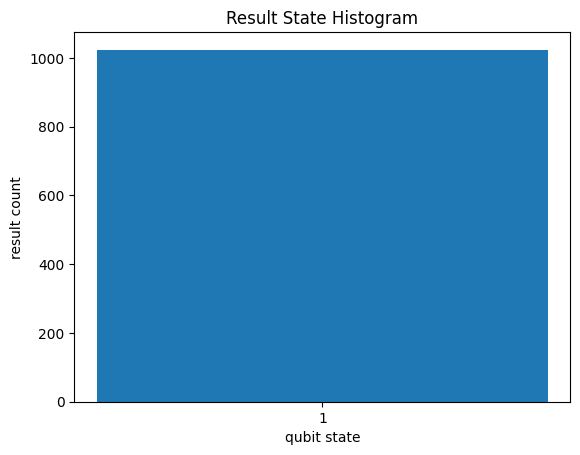

12 Qubits with 4 States per Cycle
0: ────H───Rz(-0.5π)───────────────────────────────────────────────────────────────────@───────────────────────────────────────────────────────────────@─────────────────────────────────────────────────────────@───────────────────────────────────────────────────@─────────────────────────────────────────────@───────────────────────────────────────@─────────────────────────────────@───────────────────────────@─────────────────────@───────────────@─────────@─────H───×───────────────────────M('b')───
                                                                                       │                                                               │                                                         │                                                   │                                             │                                       │                                 │                           │                     │               │         │       

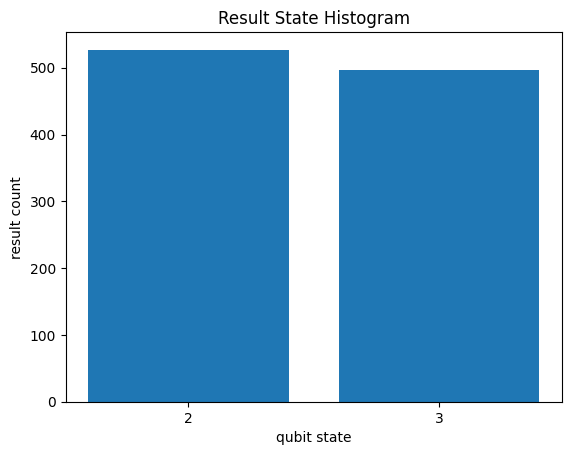

12 Qubits with 8 States per Cycle
0: ────H───Rz(-0.25π)───────────────────────────────────────────────────────────────────@───────────────────────────────────────────────────────────────@─────────────────────────────────────────────────────────@───────────────────────────────────────────────────@─────────────────────────────────────────────@───────────────────────────────────────@─────────────────────────────────@───────────────────────────@─────────────────────@───────────────@─────────@─────H───×───────────────────────M('b')───
                                                                                        │                                                               │                                                         │                                                   │                                             │                                       │                                 │                           │                     │               │         │     

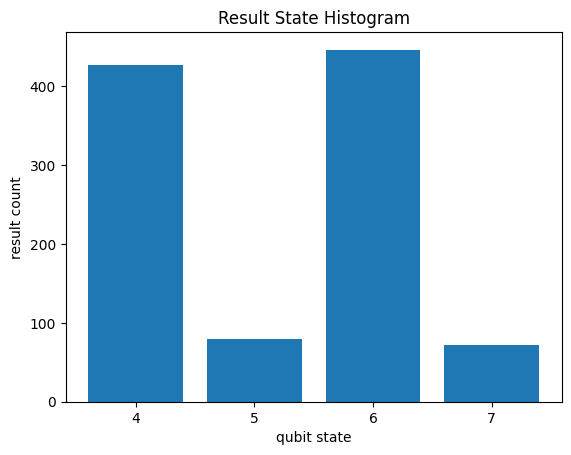

12 Qubits with 6 States per Cycle
0: ────H───Rz(-0.333π)───────────────────────────────────────────────────────────────────@───────────────────────────────────────────────────────────────@─────────────────────────────────────────────────────────@───────────────────────────────────────────────────@─────────────────────────────────────────────@───────────────────────────────────────@─────────────────────────────────@───────────────────────────@─────────────────────@───────────────@─────────@─────H───×───────────────────────M('b')───
                                                                                         │                                                               │                                                         │                                                   │                                             │                                       │                                 │                           │                     │               │         │   

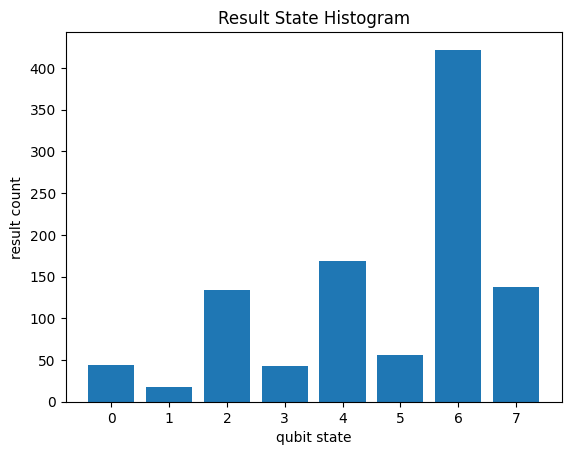

12 Qubits with a Z gate on nq / 2
0: ────H───────────────────────────────────────────────────────────────────────@───────────────────────────────────────────────────────────────@─────────────────────────────────────────────────────────@───────────────────────────────────────────────────@─────────────────────────────────────────────@───────────────────────────────────────@─────────────────────────────────@───────────────────────────@─────────────────────@───────────────@─────────@─────H───×───────────────────────M('b')───
                                                                               │                                                               │                                                         │                                                   │                                             │                                       │                                 │                           │                     │               │         │         │             

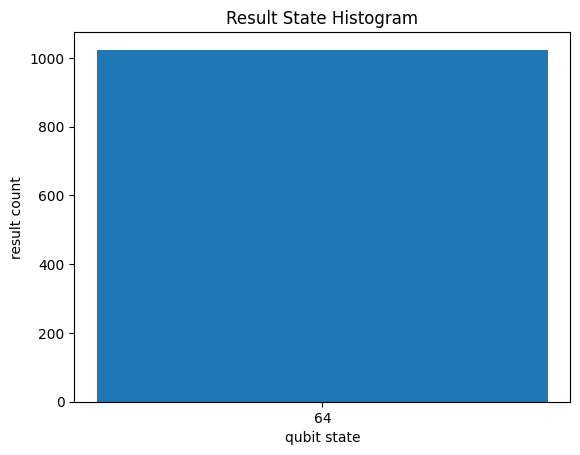

In [7]:
for nq in [8, 12]:
  for states_per_cycle in ['2', '4', '8', '6']:
    print(f'{nq} Qubits with {states_per_cycle} States per Cycle')
    run_qft_cirq(nq, states_per_cycle, plot_circuit=True)

  print(f'{nq} Qubits with a Z gate on nq / 2')
  run_qft_cirq(nq, None, plot_circuit=True)

### B : When measuring quantum systems in the computational basis, you only have access to the magnitudes of each state. In order to get a phase information, you may perform a QPE.

Estimate the (assumed unknown) angle $φ$ of a phase gate $P(φ, q_0)$ via a QPE to better than $3\%$. To test your code, start with angles $φ=π/2, π/4$ and $φ=π/3,π/6$; then choose an arbitrary angle between 0.2 and 0.9.

In [8]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate

def custom_phase_gate(phi):
    # Define the phase gate matrix
    matrix = np.array([
        [1, 0],
        [0, np.exp(1j * phi)]  # Apply phase to |1〉 state
    ])
    return UnitaryGate(matrix, label=f"P({phi:.2f})")

# Example usage
phi = np.pi/2  # 90-degree phase shift (π/2 radians)
custom_p_gate = custom_phase_gate(phi)

qc = QuantumCircuit(1)
qc.append(custom_p_gate, [0])
print(qc.draw())

   ┌─────────┐
q: ┤ P(1.57) ├
   └─────────┘


In [9]:
phi = 0.5  # Phase angle

# Create a phase gate (built-in or custom)
phase_gate = custom_phase_gate(phi)

# Add control qubit
controlled_phase = phase_gate.control(num_ctrl_qubits=1)  # 1 control qubit

# Build a 2-qubit circuit
qc = QuantumCircuit(2)
qc.append(controlled_phase, [0, 1])  # Control qubit 0, target qubit 1

print(qc.draw())

                
q_0: ─────■─────
     ┌────┴────┐
q_1: ┤ P(0.50) ├
     └─────────┘


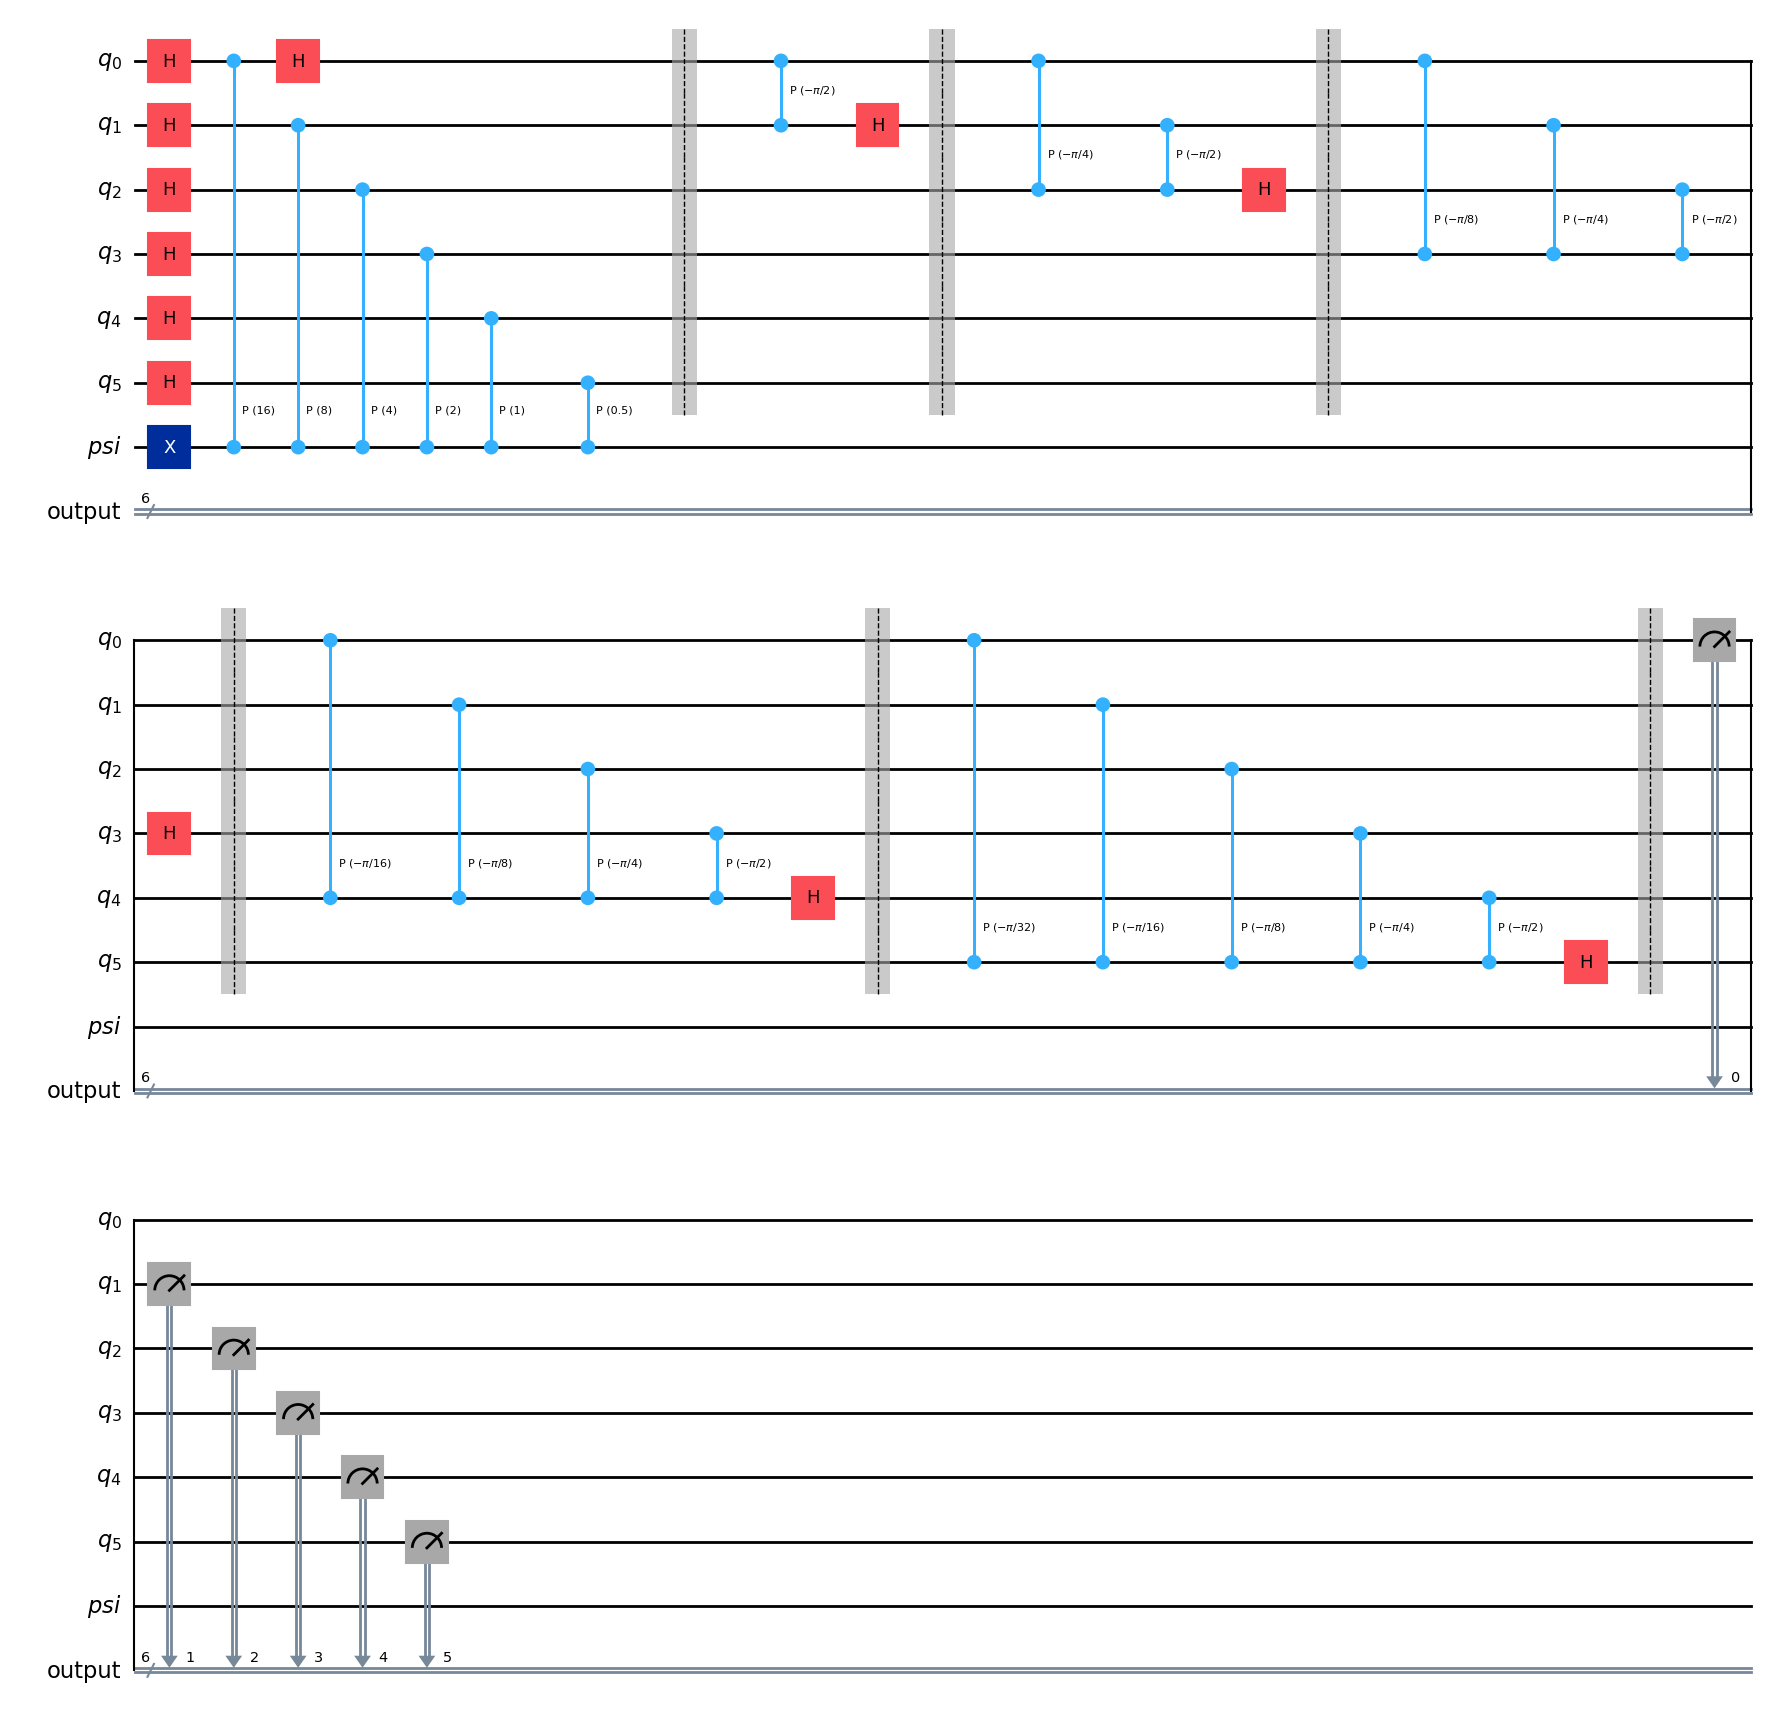

In [10]:
from qiskit_aer import Aer
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# test angle
phi = 0.5

# Phase Estimation Test
# estimation qubits
n_estimator = 6

estimator = QuantumRegister(n_estimator,"q")
psi = QuantumRegister(1, "psi")
estimator_meaure = ClassicalRegister(n_estimator, 'output')
qc = QuantumCircuit(estimator, psi, estimator_meaure,name = 'QPE')

# Prepare the target qubit in the state |1>, which is an eigenstate of P(φ).
qc.x(psi)

# Apply Hadamard gates to the estimation (counting) register.
qc.h(estimator)

# Apply controlled-U operations.
# Here U = P(φ) and for the q-th counting qubit (starting from the most significant)
# we apply U^(2^(n_count-q-1)) controlled by that qubit.

for q in range(n_estimator):
    exponent = 2 ** (n_estimator - q - 1)
    # The controlled phase gate cp(angle, control, target) applies a phase e^(i*angle)
    # when the control qubit is |1>. Hence, we apply cp(exponent * phi, control, target).

    # Replace with controlled U gate
    qc.cp(exponent * phi, q, n_estimator) ##### instead I can create some sort of U gate that I do my control over

qc = qc.compose(iqft_qiskit(n_estimator, with_swaps=False)) # swaps don't seem to be working right...

# Measure the counting register.
qc.measure(range(n_estimator), range(n_estimator))

display(qc.draw('mpl', plot_barriers=True))

In [11]:
backend = Aer.get_backend('aer_simulator')
job = backend.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
# backend = Aer.get_backend('qasm_simulator')
# result = backend.run(qc.decompose, shots=1000).result()
# counts = result.get_counts()

# Get the outcome with the highest probability.
measured_str = max(counts, key=counts.get)
measured_val = int(measured_str, 2)

# The binary outcome corresponds to a fraction m / 2^n_count.
# Since the eigenphase (normalized) is φ/(2π), we recover φ by:
phi_est = measured_val / (2 ** n_estimator) * 2 * math.pi
# return qc, counts, phi_est

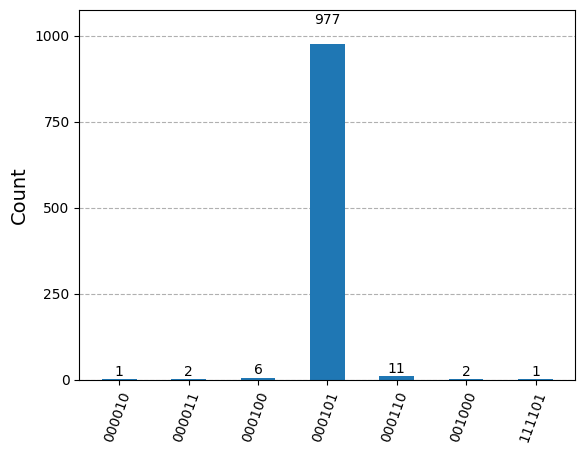

In [12]:
plot_histogram(counts)

In [13]:
phi

0.5

In [14]:
phi_est

0.4908738521234052

In [15]:
from qiskit.circuit.library import QFT

def qpe_circuit(n_estimation_qubits, U_gate, measure = True):
    if measure:
        c_n_estimation_qubits = n_estimation_qubits
    else:
         c_n_estimation_qubits = 0
    qc = QuantumCircuit(n_estimation_qubits + 1, c_n_estimation_qubits, name = 'QPE')

    # Initialize target qubit to |1⟩ (eigenstate of U)
    if measure:
        qc.x(n_estimation_qubits)

    # Apply Hadamard to estimation qubits
    for qubit in range(n_estimation_qubits):
        qc.h(qubit)

    # Apply controlled-U^(2^k) for each estimation qubit k
    for k in range(n_estimation_qubits):
        # Apply U^(2^k) = U repeated 2^k times (or use its algebraic property)
        # For phase gates: U^(2^k) = P(2^k * φ)
        cU_k = U_gate.control(1)
        for _ in range(2**k):
            qc.append(cU_k, [k, n_estimation_qubits])

    # Apply inverse QFT
    qc.append(QFT(n_estimation_qubits, inverse=True), range(n_estimation_qubits))
    # qc = iqft_qiskit(qc, with_swaps=True)

    if measure:
        # Measure estimation register
        qc.measure(range(n_estimation_qubits), range(n_estimation_qubits))

    return qc

In [16]:
from qiskit import transpile
from qiskit_aer import Aer

# Example setup
n = 8  # Number of estimation qubits
phi_unknown = 0.25  # True phase (unknown in practice)
U = custom_phase_gate(phi_unknown)  # U contains the hidden φ

qc = qpe_circuit(n, U)
# display(qc.draw('mpl', plot_barriers=True))

# Simulate using Aer
backend = Aer.get_backend('aer_simulator')  # Use Aer's simulator
transpiled_qc = transpile(qc, backend)  # Decompose custom gates
result = backend.run(transpiled_qc).result()
counts = result.get_counts()
# print(counts)

In [17]:
# Step 1: Find the most common bitstring
most_common_bitstring = max(counts, key=lambda k: counts[k])

# Step 2: Compute theta
n = len(most_common_bitstring)  # Number of estimation qubits
theta = int(most_common_bitstring, 2) / (2 ** n)

# Step 3: Compute phi
phi = theta * 2 * np.pi

print(f"Most common bitstring: {most_common_bitstring}")
print(f"Estimated θ (phi/(2π)): {theta}")
print(f"Estimated phase ϕ: {phi} radians")

Most common bitstring: 00001010
Estimated θ (phi/(2π)): 0.0390625
Estimated phase ϕ: 0.2454369260617026 radians


### C: Solve the small system of linear equations using the HHL algorithm, given by:

$$
A = \begin{bmatrix}
a & b\\
b & a
\end{bmatrix}
,  \vec{b} = \begin{bmatrix}
cos\theta \\
sin\theta
\end{bmatrix}
$$

To test the code, start with values $a = 1; b = -\frac{1}{3}; \theta=0 $; then sweep the angle between $0$ and $\pi$.

In [18]:
import numpy as np
from scipy.linalg import expm

# Define the matrix A
A = np.array([[1, -1/3], [-1/3, 1]])

# Compute e^(iA)
iA = 1j * A  # Multiply by i (imaginary unit)
e_iA = expm(iA)  # Matrix exponential

# Check unitarity (U†U ≈ I)
product = e_iA.conj().T @ e_iA
print("Unitarity check (should be close to identity):\n", np.round(product, 10))

from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate

# Create a custom gate from e^(iA)
A_gate = UnitaryGate(e_iA, label='e^{iA}')

# Add the gate to a circuit
qc = QuantumCircuit(1)
qc.append(A_gate, [0])

# Visualize the circuit
print(qc.draw())

Unitarity check (should be close to identity):
 [[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]
   ┌────────┐
q: ┤ e^{iA} ├
   └────────┘


In [19]:
product

array([[1.00000000e+00+0.j, 5.55111512e-17+0.j],
       [5.55111512e-17+0.j, 1.00000000e+00+0.j]])

In [20]:
np.round(product, 10) == np.identity(2)

array([[ True,  True],
       [ True,  True]])

In [21]:
n_cl = A.size # arbritrary to determine size of clock qubits for phase estimation

# Start by initializing registers for each type of qubit
ancilla = QuantumRegister(1, name='a')
b_reg = QuantumRegister(1, name = 'b') # for this example only
clock = QuantumRegister(n_cl, name = 'cl')

def b(theta):
    return [np.cos(theta), np.sin(theta)]

qc = QuantumCircuit(ancilla, clock, b_reg)

# initialzie b using qiskit state vector preparation
b_statevector = b(0)
qc.prepare_state(b_statevector, b_reg)

# Perform phase estimation
qc_qpe = qpe_circuit(n_estimation_qubits = n_cl, U_gate = A_gate, measure = False)
qc.compose(qc_qpe, [1,2,3,4,5], inplace=True) # I want this to print just as a block

qc.draw()

»
   a: ──────────────────────────────────────────────────────────────────»
                ┌───┐                                                   »
cl_0: ──────────┤ H ├───────────────■───────────────────────────────────»
                ├───┤               │                                   »
cl_1: ──────────┤ H ├───────────────┼─────────■─────────■───────────────»
                ├───┤               │         │         │               »
cl_2: ──────────┤ H ├───────────────┼─────────┼─────────┼─────────■─────»
                ├───┤               │         │         │         │     »
cl_3: ──────────┤ H ├───────────────┼─────────┼─────────┼─────────┼─────»
      ┌─────────┴───┴──────────┐┌───┴────┐┌───┴────┐┌───┴────┐┌───┴────┐»
   b: ┤ State Preparation(1,0) ├┤ e^{iA} ├┤ e^{iA} ├┤ e^{iA} ├┤ e^{iA} ├»
      └────────────────────────┘└────────┘└────────┘└────────┘└────────┘»
«                                                                            »
«   a: ──────────────────────────────────────────────────────────────────────»
«                                                                            »
«cl_0: ──────────────────────────────────────────────────────────────────────»
«                                                                            »
«cl_1: ──────────────────────────────────────────────────────────────────────»
«                                                                            »
«cl_2: ────■─────────■─────────■─────────────────────────────────────────────»
«          │         │         │                                             »
«cl_3: ────┼─────────┼─────────┼─────────■─────────■─────────■─────────■─────»
«      ┌───┴────┐┌───┴────┐┌───┴────┐┌───┴────┐┌───┴────┐┌───┴────┐┌───┴────┐»
«   b: ┤ e^{iA} ├┤ e^{iA} ├┤ e^{iA} ├┤ e^{iA} ├┤ e^{iA} ├┤ e^{iA} ├┤ e^{iA} ├»
«      └────────┘└────────┘└────────┘└────────┘└────────┘└────────┘└────────┘»
«                                                       
«   a: ─────────────────────────────────────────────────
«                                              ┌───────┐
«cl_0: ────────────────────────────────────────┤0      ├
«                                              │       │
«cl_1: ────────────────────────────────────────┤1      ├
«                                              │  IQFT │
«cl_2: ────────────────────────────────────────┤2      ├
«                                              │       │
«cl_3: ────■─────────■─────────■─────────■─────┤3      ├
«      ┌───┴────┐┌───┴────┐┌───┴────┐┌───┴────┐└───────┘
«   b: ┤ e^{iA} ├┤ e^{iA} ├┤ e^{iA} ├┤ e^{iA} ├─────────
«      └────────┘└────────┘└────────┘└────────┘

In [22]:
def HHL(A, b, n_cl):
    ancilla = QuantumRegister(1, name = 'a')
    b_reg = QuantumRegister(np.log2(b.size()), name = 'b')
    clock = QuantumRegister(n_cl, name = 'cl')

    # Check to see that A gate is Hermitian and will be able to create unitary
    # Compute e^(iA)
    iA = 1j * A  # Multiply by i (imaginary unit)
    e_iA = expm(iA)  # Matrix exponential
    # Check unitarity (U†U ≈ I)
    product = e_iA.conj().T @ e_iA
    if np.round(product, 10) == np.identity(2):
        print("Unitarity check (should be close to identity):\n", np.round(product, 10))
    else:
        return print("A is not Hermitian")

In [23]:
qc = QuantumCircuit(10,8)

qpe_qc = qpe_circuit(n_estimation_qubits = 8, U_gate = A_gate, measure = False)
qc.append(qpe_qc, [0,1,2,3,4,5,6,7,8])
qc.draw()

┌──────┐
q_0: ┤0     ├
     │      │
q_1: ┤1     ├
     │      │
q_2: ┤2     ├
     │      │
q_3: ┤3     ├
     │      │
q_4: ┤4 QPE ├
     │      │
q_5: ┤5     ├
     │      │
q_6: ┤6     ├
     │      │
q_7: ┤7     ├
     │      │
q_8: ┤8     ├
     └──────┘
q_9: ────────
             
c: 8/════════

In [24]:
# Create controlled version (default: 1 control qubit)
controlled_gate = A_gate.control()

# Build circuit with control and target qubits
qc = QuantumCircuit(2)
qc.append(controlled_gate, [0, 1])  # Control qubit 0, target qubit 1

# Visualize
print(qc.draw())

               
q_0: ────■─────
     ┌───┴────┐
q_1: ┤ e^{iA} ├
     └────────┘


Step 1: initialize $\ket{0}_a \ket{0}_Q \ket{0}_R \ket{b}_M = \sum_{j=1}^N \beta_j \ket{0}_a \ket{0}_Q \ket{0}_R \ket{u_j}_M$

Step 2: perform QPE using $e^{iAt}$ and map eigenvalues $\lambda_j$ into register $R$: 
$$\to \sum_{j=1}^N \beta_j \ket{0}_a \ket{0}_Q \ket{\lambda_j}_R \ket{u_j}_M$$

Step 3: invert the eigenvalues and map them to register $Q$:
$$\to \sum_{j=1}^N \beta_j \ket{0}_a \ket{\lambda_j^{-1}}_Q \ket{\lambda_j}_R \ket{u_j}_M$$
Step 4: rotate the ancilla qubit for each $j$ using a controlled rotation on the $\ket{0}_a$ qubit for a predefined $c<\lambda_{max}$:
$$\to  \sum_{j=1}^N \beta_j \left( \sqrt{1-\frac{c^2}{\lambda_j^2}}\ket{0}_a + \frac{c}{\lambda_j}\ket{1}_a\right) \ket{\lambda_j^{-1}}_Q \ket{\lambda_j}_R \ket{u_j}_M$$
Step 4: perform the opposite operation fo Steps 1 and 2 to reset registers $R$ and $Q$:
$$\to  \sum_{j=1}^N \beta_j \left( \sqrt{1-\frac{c^2}{\lambda_j^2}}\ \ket{0}_a + \frac{c}{\lambda_j}\ket{1}_a\right) \ket{0}_Q \ket{0}_R \ket{u_j}_M$$
Step 5: measure the ancilla qubit: if the $\ket{1}_a$ state is obtained, the resulting vector in the $M$ register is $\ket{x}_M$:

In [25]:
# Step 1 initialize a, q, R, b

### D (Extra Credit); Set up a circuit solving the SLE given under "Notes" to the HHL algorithm in QPE_HHL.ipynb

$$ A=\frac{1}{4} \begin{pmatrix} 15 & 9 & 5 & -3 \\ 9 & 15 & 3 & -5 \\
5 & 3 & 15 & -9 \\ -3 & -5 & -9 & 15 \end{pmatrix} \ , 
\quad \vec{b} =\frac{1}{2}\begin{pmatrix} 1 \\ 1 \\ 1 \\ 1 \end{pmatrix}$$